In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize(shm_size_mb=4000, progress_bar=True)

New pandarallel memory created - Size: 4000 MB
Pandarallel will run on 12 workers


In [59]:
df = pd.read_csv("/home/fvalle/phd/datasets/merged/mainTable.csv", index_col=0)
df_files = pd.read_csv("/home/fvalle/phd/datasets/merged/files.dat", index_col=0)
df_files = df_files[df_files.index.isin(df.columns)]
df_files['primary_site'].unique()

array(['Thyroid', 'Prostate', 'Colon', 'Esophagus', 'Salivary Gland',
       'Liver', 'Lung', 'Stomach', 'Breast', 'Uterus'], dtype=object)

In [60]:
#fpkm threshholds
df = df.where(df<1e5,1e5)
df = df.where(df>1e-1,0)

In [61]:
def get_site_columns(site='Colon'):
    return df_files[df_files['primary_site']==site].index.values

def get_not_site_columns(site='Colon'):
    return df_files[df_files['primary_site']!=site].index.values

In [62]:
gene = df.index[130]

In [63]:
HDE_genes = []
sigmadiff = []

A2ML1
A4GNT
AADAC
AARD
ABAT
ABCA3
ABCA4
ABCA6
ABCA8
ABCB1


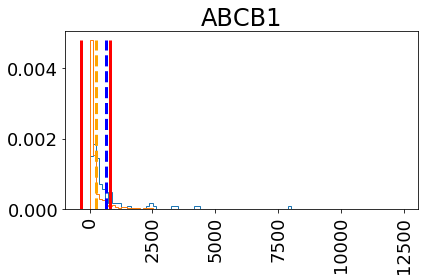

ABCB11
ABCB4
ABCC11
ABCC12
ABCC2
ABCC4
ABCC6
ABI3BP
ABLIM3
ABRA
AC002310.13
AC003002.4
AC006486.9
AC006538.4
AC007919.2
AC016559.1
AC017028.1
AC018445.1
AC018816.3
AC018867.2
AC079354.2
AC092291.2
AC110615.1
AC138517.1


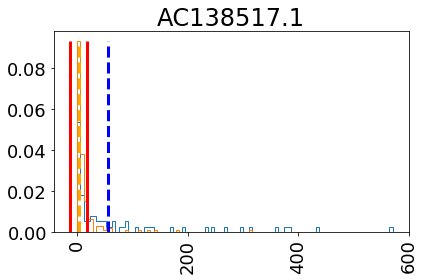

AC140061.12
AC142381.1
ACAA2
ACACB
ACADS


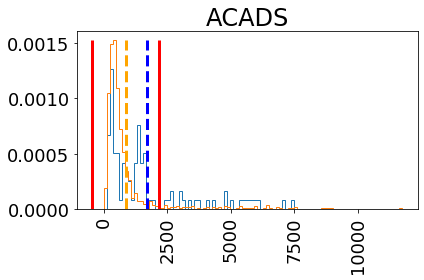

ACADSB
ACAN
ACAT1
ACE
ACER1
ACKR3
ACMSD
ACOT12
ACOX2
ACP5
ACPP
ACPT
ACSBG1
ACSL1
ACSL4
ACSL5


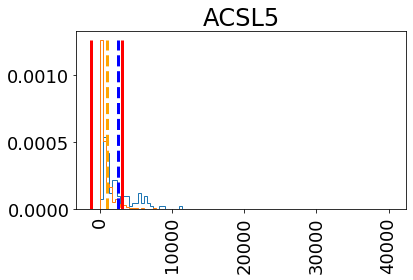

ACSM1
ACSM2A
ACSM2B
ACSM3
ACSM5
ACSS3
ACTA1
ACTC1
ACTL6B
ACTN2
ACVR1C
ACY3
ADAD1
ADAM18
ADAM28
ADAM33
ADAMDEC1


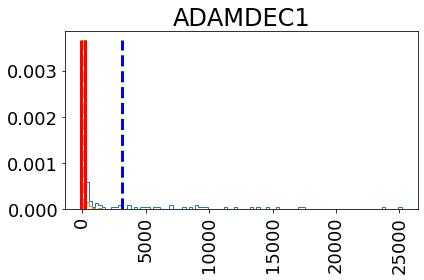

ADAMTS8
ADAMTS9
ADAMTSL2
ADAP1


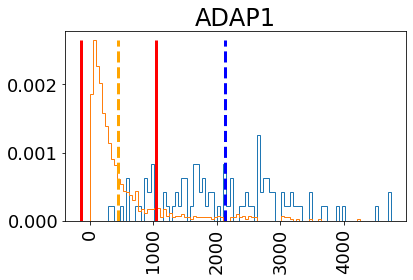

ADCY1
ADCY5
ADH1A
ADH1B
ADH4
ADH6
ADH7
ADIPOQ
ADM
ADRA1A
ADRA2C
ADRB2
ADSSL1
ADTRP


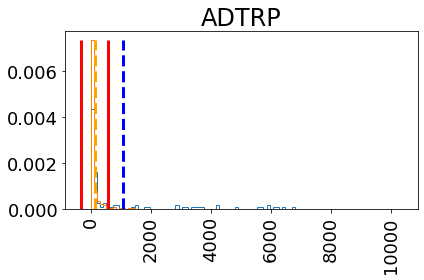

AFAP1L2
AFF3
AFM
AFP
AGER
AGMAT
AGMO
AGPAT9
AGR3
AGT
AGTR1
AGXT
AHCYL2


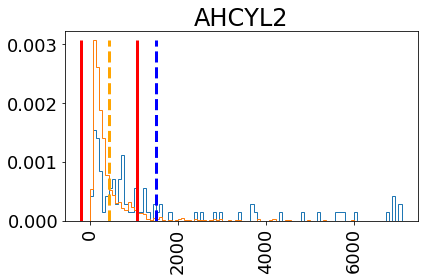

AHNAK2
AHSG
AIF1L
AIFM3


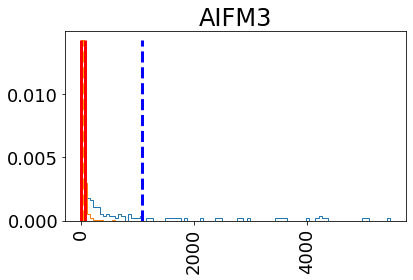

AIM1
AIM1L
AK5
AKAP14
AKR1B1
AKR1B10
AKR1B15
AKR1C1
AKR1C2
AKR1C3
AKR1C4
AKR1CL1
AKR1D1
AKR7A3
AL022328.1
AL049829.1
AL121963.1
AL158147.2
AL162431.1
AL163636.6
AL353354.2
AL359693.1
AL583828.1
AL590235.1
AL590714.1
AL591684.1
ALAS1
ALB
ALDH1A2
ALDH1A3
ALDH1L1
ALDH3A1
ALDH3B1
ALDH3B2
ALDH4A1
ALDH6A1
ALDH8A1
ALDOB
ALDOC
ALOX12
ALOX12B
ALOX15
ALOX15B
ALOX5
ALOX5AP
ALOXE3
ALPL
ALPP
ALPPL2
ALS2CL
AMACR
AMBP
AMDHD1
AMIGO2
AMN


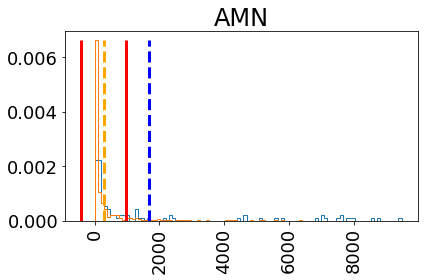

AMPD1
AMTN
AMY1A
AMY1B
AMY1C
AMY2A


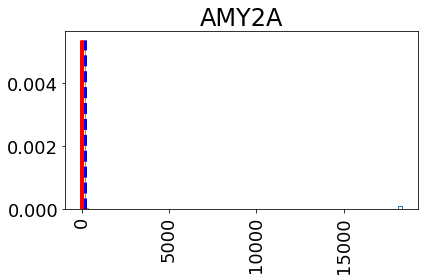

ANG
ANGPTL1
ANGPTL3
ANGPTL4
ANGPTL6
ANK1
ANKFN1
ANKRD1
ANKRD2
ANKRD22
ANKRD23
ANKRD29
ANKRD30B
ANKRD33
ANKRD35
ANKRD37
ANO1
ANO7
ANO9


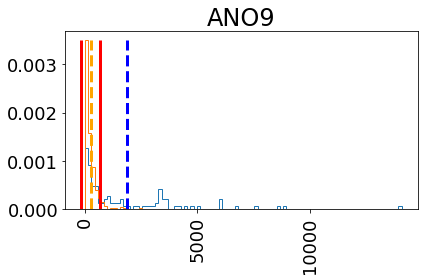

ANPEP


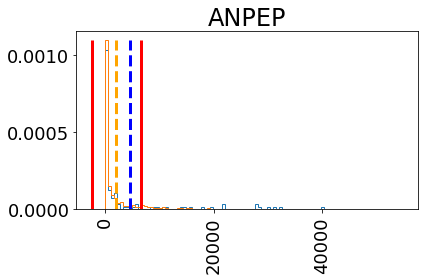

ANXA10
ANXA13


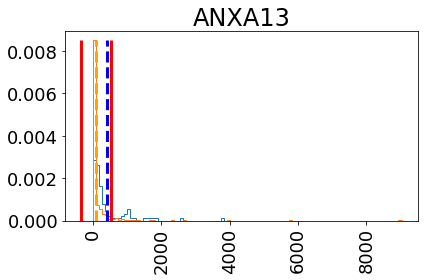

ANXA8
ANXA8L1
ANXA8L2
ANXA9
AOC1


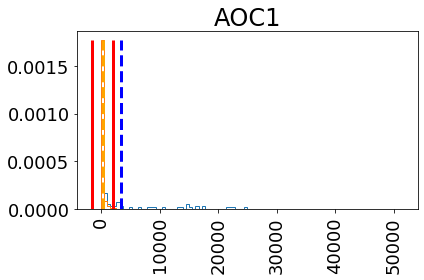

AOC3
AOX1
AP000349.1
AP001350.1
AP001362.1
AP001579.1
AP001816.1
APCDD1
APCS
APLP1
APOA1
APOA2
APOA4
APOA5
APOB
APOBEC2
APOBEC3A
APOBR


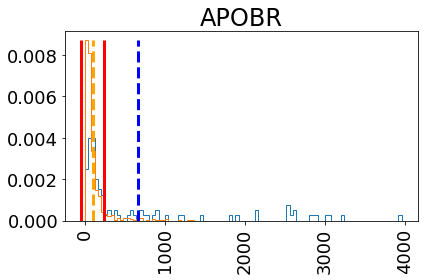

APOC1
APOC3
APOC4
APOC4-APOC2
APOF
APOH
APOM
AQP1
AQP10
AQP12B


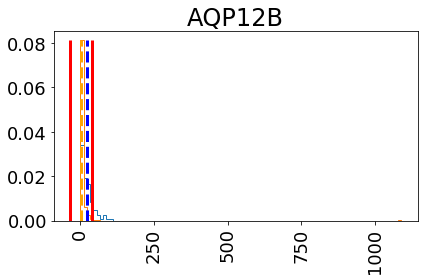

AQP2
AQP3
AQP4
AQP5
AQP7
AQP8


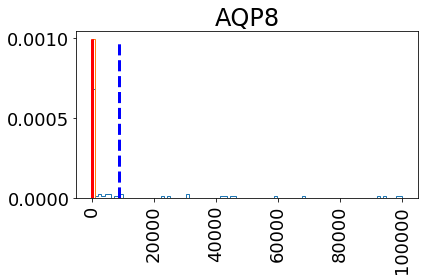

AQP9
AQPEP
AR


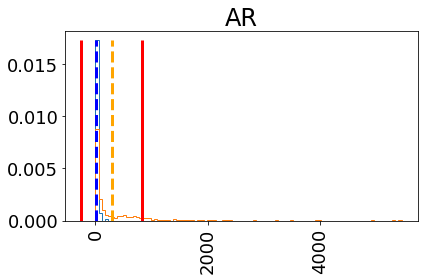

ARC
AREG
AREGB
ARG1
ARG2
ARHGAP36
ARHGEF4
ARL14


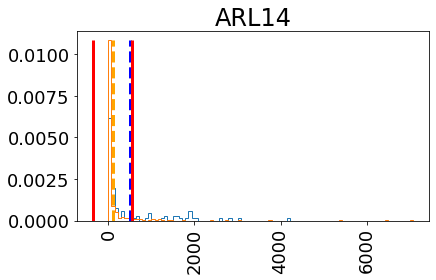

ARMC3
ARMS2
ARPP21
ARSE
ART1
ART3
ASAH2
ASB11
ASB2
ASB5
ASCL1
ASGR1
ASGR2
ASIC2
ASIP


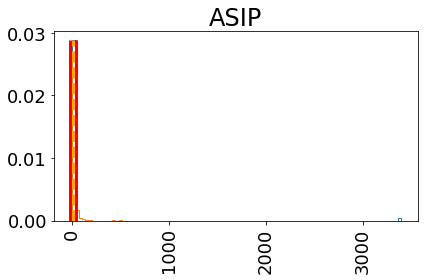

ASL
ASPDH
ASPG
ASPN
ASPRV1
ASRGL1
ATF3
ATF5
ATG9B
ATOH8
ATP10B


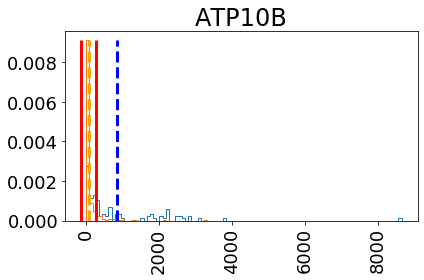

ATP11A
ATP12A
ATP13A4
ATP13A5
ATP1A2
ATP1A4
ATP2A1
ATP2B2
ATP2B3


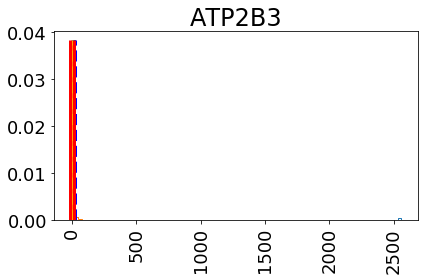

ATP4A
ATP4B
ATP6V0A4
ATP6V1B1
ATP6V1C2
AURKB
AVP


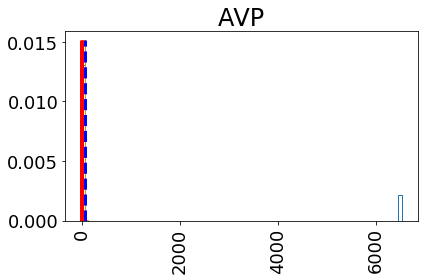

AVPR1A
AWAT1
B3GALT5


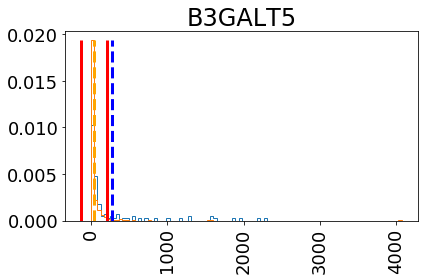

B3GNT3


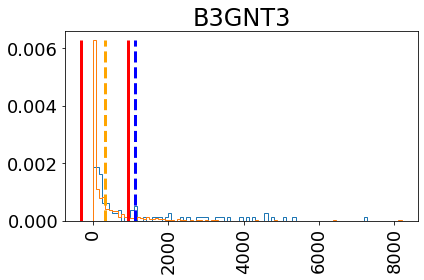

B3GNT5
B3GNT6


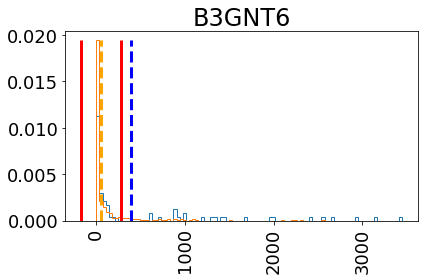

B3GNT7


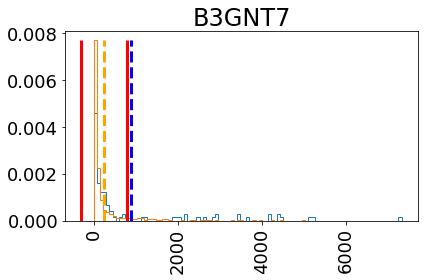

B4GALNT2


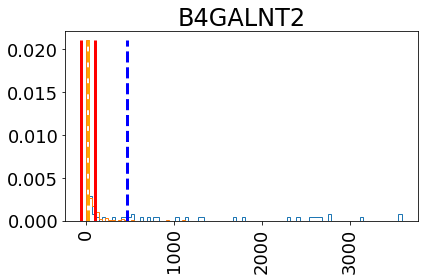

B4GALNT4
BAAT
BAI2
BAIAP2L1
BAIAP2L2


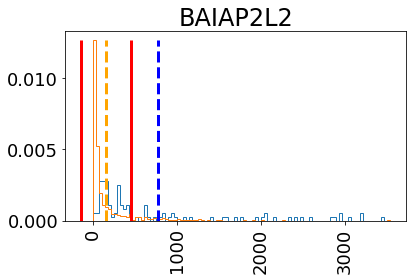

BAMBI
BARX1
BARX2
BBOX1
BCAS1


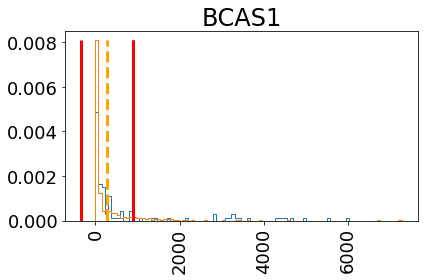

BCAT1
BCHE
BCL2A1
BCL2L15


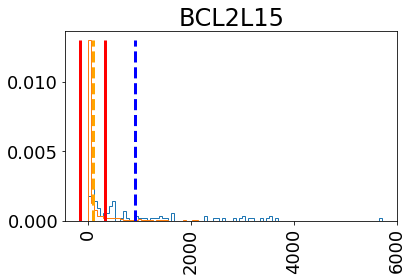

BCO2
BDH1
BEST2


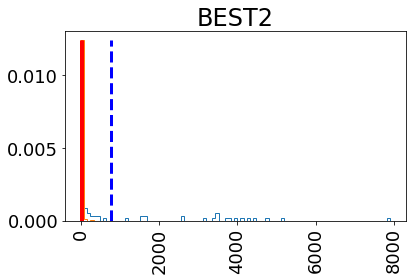

BEST3
BEST4


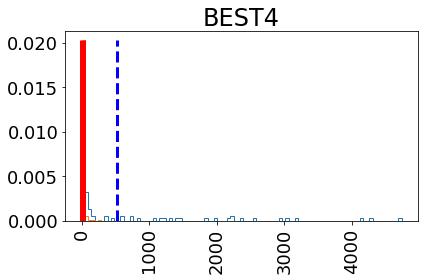

BEX1
BEX2
BEX5
BHLHA15
BHLHE41
BHMT
BHMT2
BIRC3
BIRC5
BMP2
BMP7
BMP8A
BMPR1B
BNC1
BNIPL
BPIFA1
BPIFB1
BPIFB2
BPIFB4
BRDT
BRINP2
BTN1A1
BTNL3


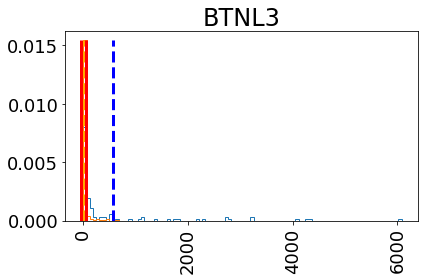

BTNL8


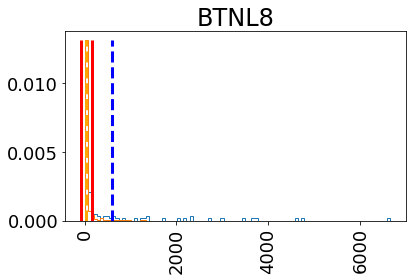

BTNL9
BX842679.1
C10orf32-ASMT
C10orf71
C10orf90
C10orf99


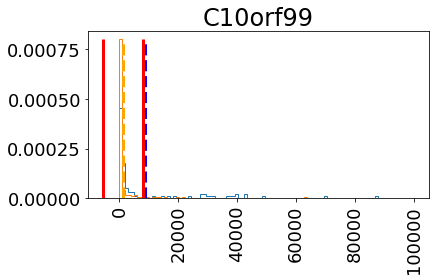

C11orf53
C11orf86
C11orf88
C11orf96
C12orf36


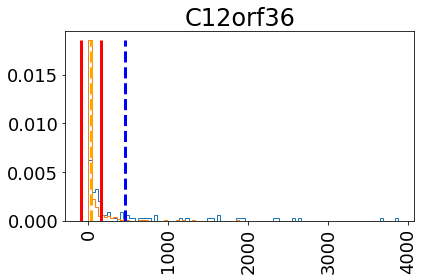

C12orf39
C14orf105
C14orf180
C14orf23
C15orf48


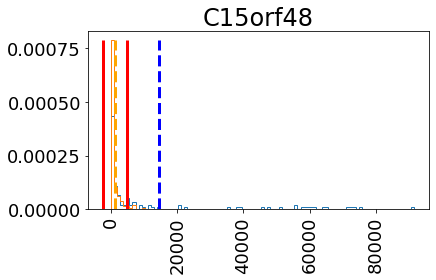

C16orf89
C19orf59
C19orf77
C19orf80
C1QL1
C1QL4
C1QTNF3
C1orf105
C1orf106


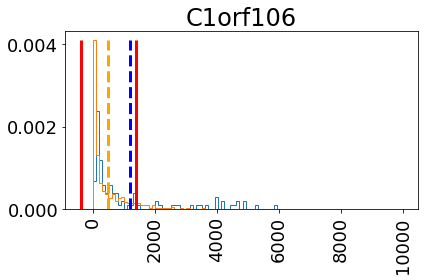

C1orf110
C1orf116
C1orf162
C1orf168
C1orf170
C1orf177
C1orf186
C1orf189
C1orf194
C1orf64
C1orf68
C1orf87
C2
C20ORF135
C20orf166
C20orf85
C21orf37
C22orf24
C22orf42
C2CD4A
C2orf40
C2orf50
C2orf54
C2orf72
C2orf82
C2orf88


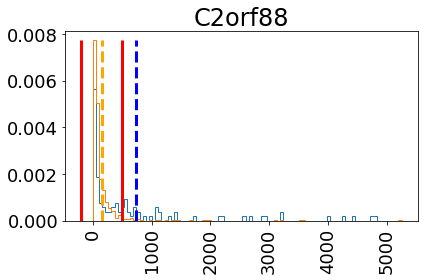

C3
C3orf72
C4BPA
C4BPB
C4orf51
C5
C5orf27
C5orf38
C5orf49
C5orf52


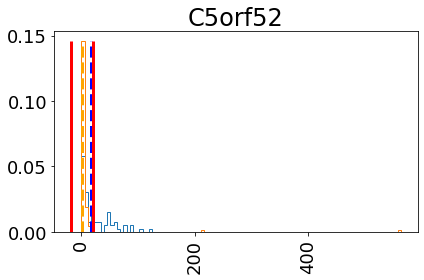

C6
C6orf118
C6orf132
C6orf141
C6orf15
C6orf223
C6orf58
C7
C8A
C8B
C8G
C8orf22
C8orf47
C8orf74
C8orf87
C9
C9orf135
C9orf152


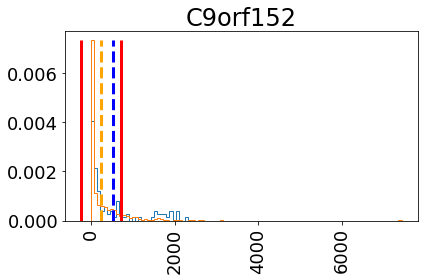

C9orf169
C9orf24
CA1


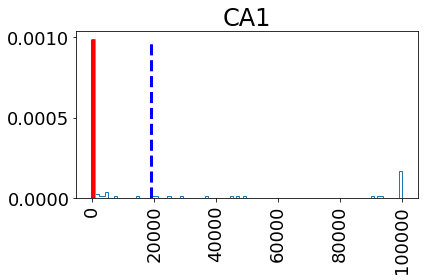

CA12


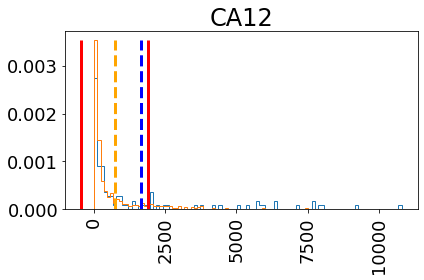

CA2


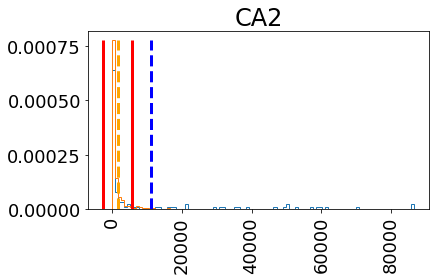

CA3
CA4


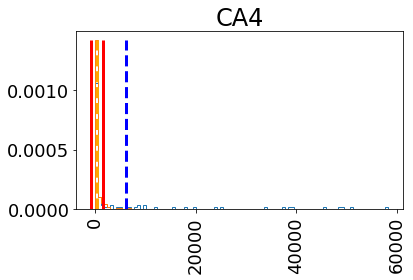

CA5A
CA6
CA7


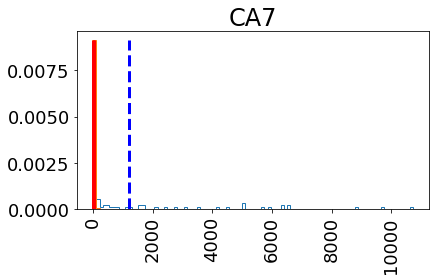

CA8
CA9
CABYR
CACNA1H
CACNA1S
CACNA2D2
CACNG4
CACNG6
CACNG7
CADM3
CALB1
CALB2
CALCA
CALCB
CALCRL
CALML3
CALML4


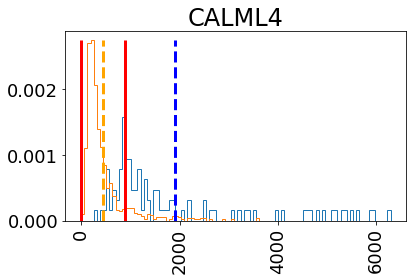

CALML5
CALML6
CAMP
CAPN12
CAPN13
CAPN14
CAPN5


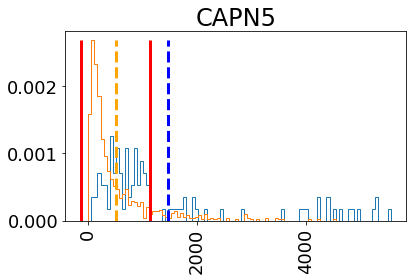

CAPN6
CAPN8
CAPN9


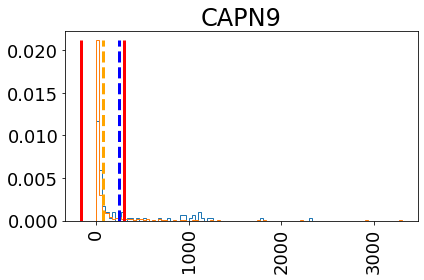

CAPNS2
CAPS
CAPSL
CARD18
CARTPT
CASP1
CASP14
CASQ1
CASQ2
CATSPERD
CAV3
CBLN2
CBR3
CBS
CCDC152
CCDC33
CCDC37
CCDC64B
CCDC74A
CCDC74B
CCDC80
CCK
CCL1
CCL11


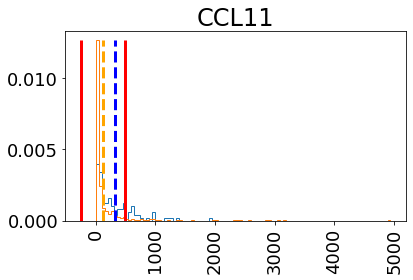

CCL13
CCL14
CCL15


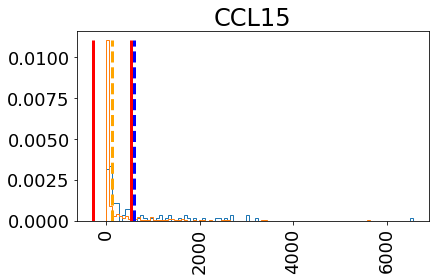

CCL15-CCL14
CCL16
CCL18
CCL19
CCL20
CCL21
CCL23
CCL24


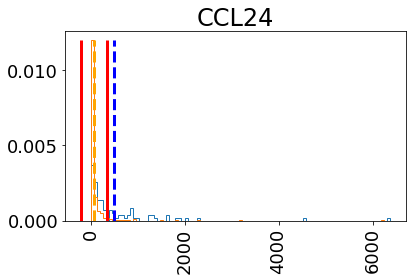

CCL25
CCL26
CCL27
CCL28
CCL5
CCNA1
CCNE1
CD14
CD163
CD164L2
CD1A
CD207
CD248
CD300LG
CD302
CD36
CD37
CD38
CD4
CD52
CD53
CD5L
CD69
CD79A
CDA
CDC20
CDC20B
CDC42EP5


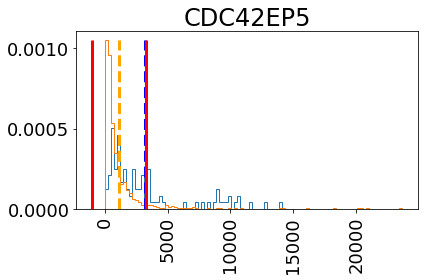

CDCA7


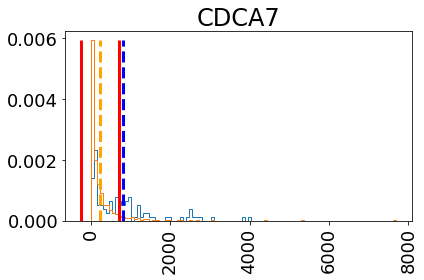

CDH11
CDH15
CDH16
CDH17


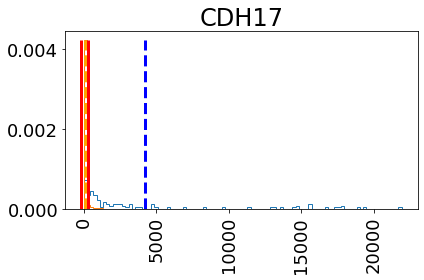

CDH3
CDHR1


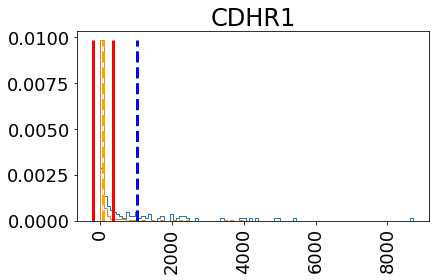

CDHR2


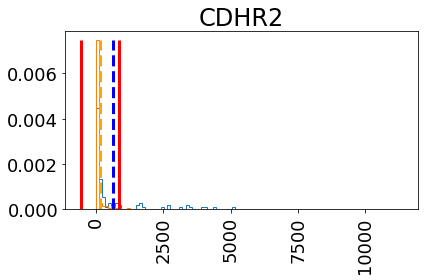

CDHR4
CDHR5


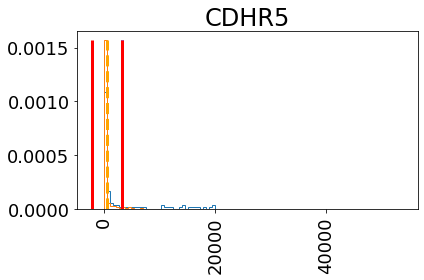

CDKN2A
CDKN2B
CDO1
CDSN
CDX1


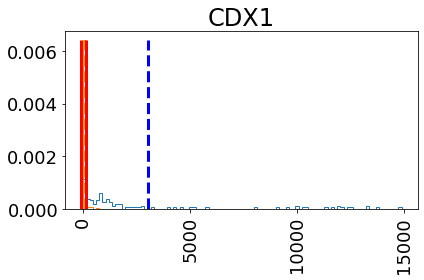

CDX2


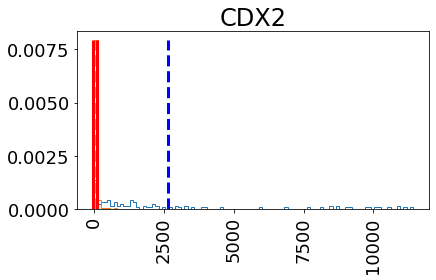

CEA
CEACAM1


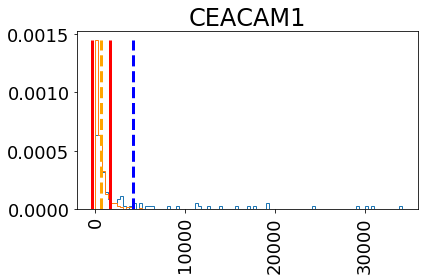

CEACAM5


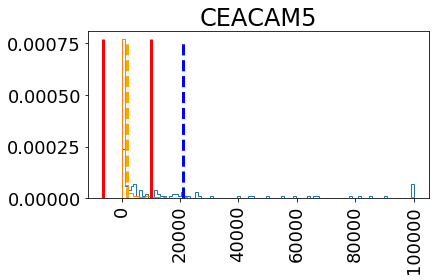

CEACAM6
CEACAM7


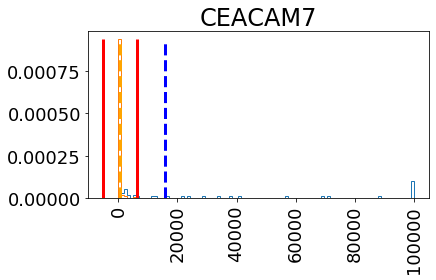

CECR1
CEL


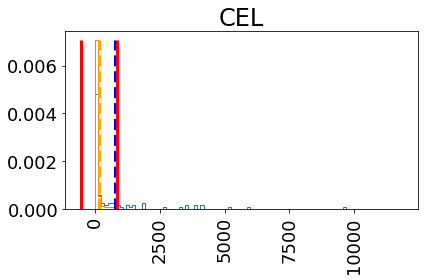

CELA2A


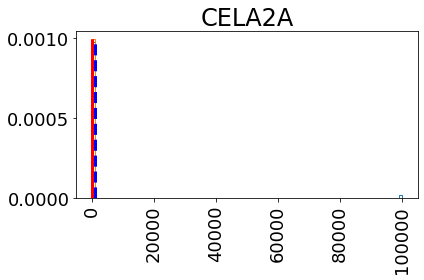

CELA2B


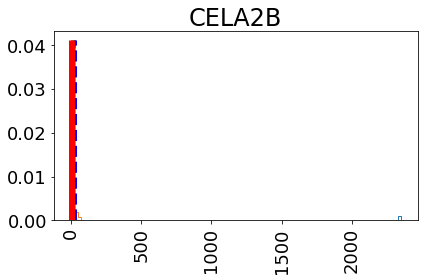

CELA3A


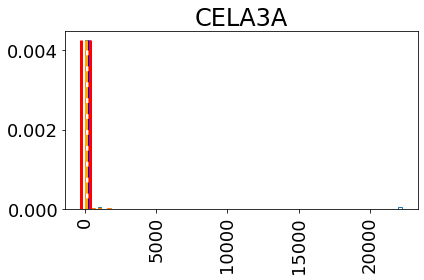

CELA3B
CELF2
CELF3


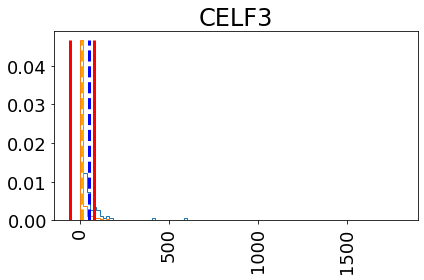

CER1


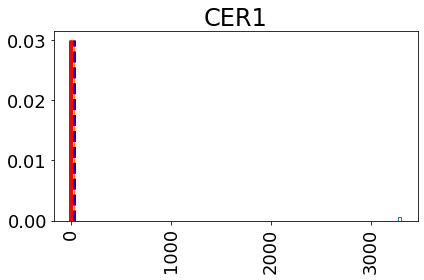

CERS3
CES1
CES3


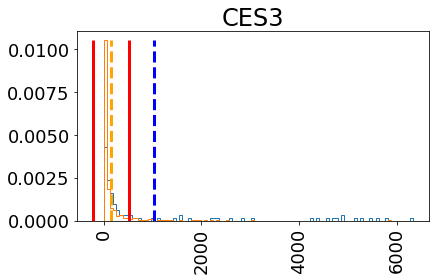

CETP
CFD
CFH
CFHR1
CFHR2
CFHR3
CFI
CFP
CFTR


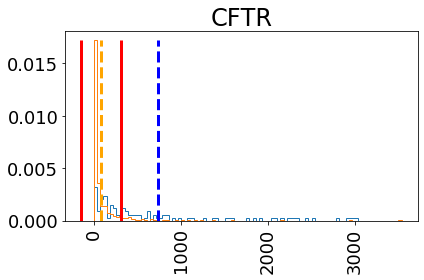

CGA
CGB
CGB2
CGB5
CHAC1
CHAD
CHGA
CHGB
CHI3L1
CHI3L2
CHIA
CHIC2
CHIT1
CHL1
CHP2


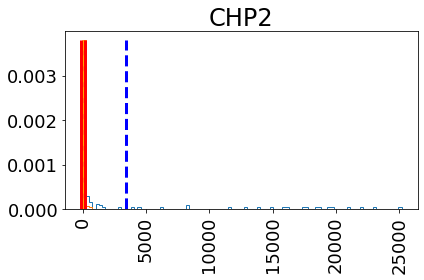

CHRDL1
CHRDL2
CHRM1
CHRNA1
CHRNA2
CHRNA4
CHRNA9
CHRND
CHST13
CHST4
CHST5


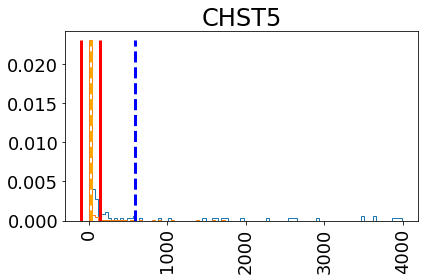

CHST9
CIB4
CIDEA
CIDEB
CIDEC
CILP
CILP2
CITED1
CITED4
CKM
CKMT1A


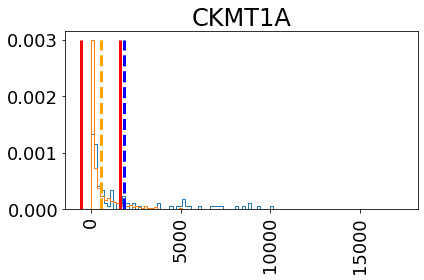

CKMT1B


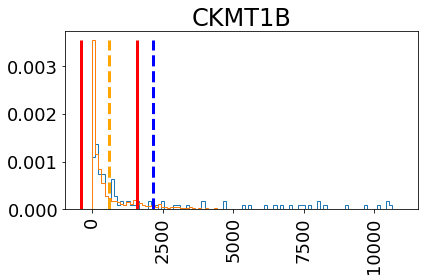

CKMT2
CLC
CLCA1


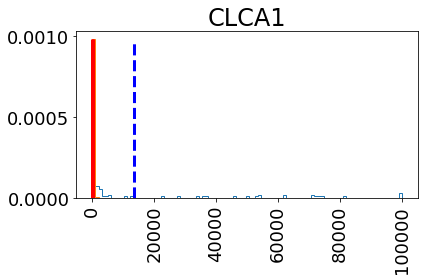

CLCA2
CLCA4


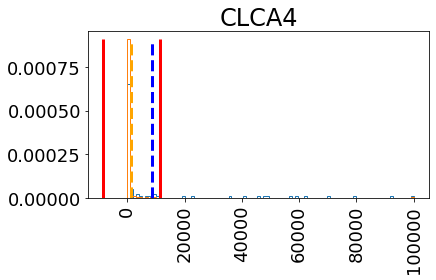

CLCNKA
CLCNKB
CLDN1
CLDN10
CLDN14
CLDN15


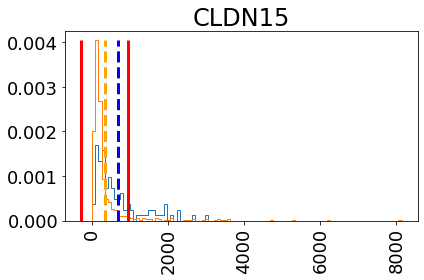

CLDN16
CLDN18
CLDN19
CLDN2
CLDN22
CLDN23


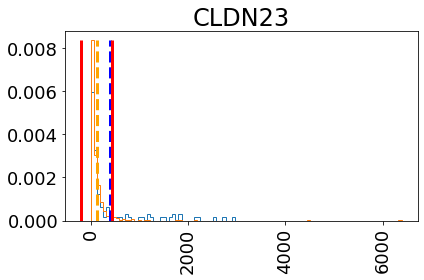

CLDN3


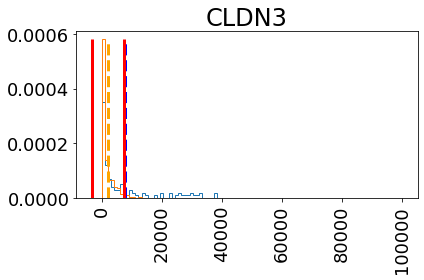

CLDN5
CLDN6
CLDN7


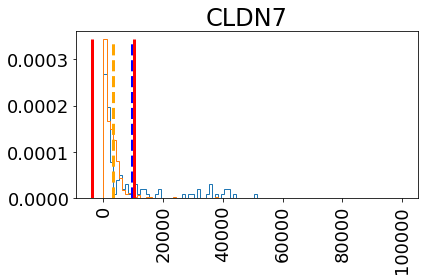

CLDN8


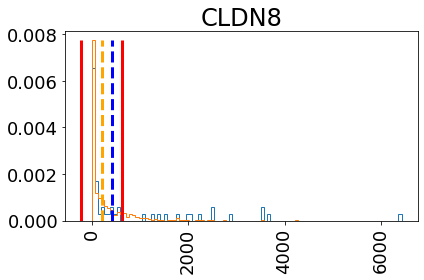

CLEC1B
CLEC2A
CLEC2B
CLEC3A
CLEC4G
CLEC4M
CLEC7A
CLIC2
CLIC3
CLIC5
CLIC6
CLIP3
CLLU1OS
CLMP
CLPS


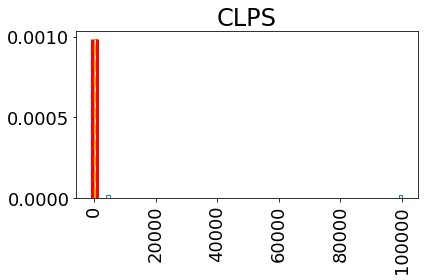

CLPSL1
CLPSL2
CLRN3


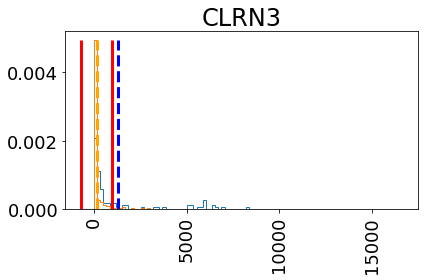

CLSTN2
CMBL
CMYA5
CNDP1
CNFN
CNGB1
CNTFR
CNTNAP2
COCH
COL10A1
COL11A1
COL11A2
COL12A1
COL14A1
COL17A1
COL19A1
COL20A1
COL23A1
COL2A1
COL4A3
COL4A5
COL4A6
COL5A1
COL7A1
COL8A1
COL9A1
COL9A2
COL9A3
COLEC10
COLEC11
COLEC12
COMP
CORO6
COX6A2
COX7A1
COX7B2
COX8C
CP
CPA1
CPA2
CPA3
CPA4
CPAMD8
CPB1
CPB2
CPLX2
CPLX3


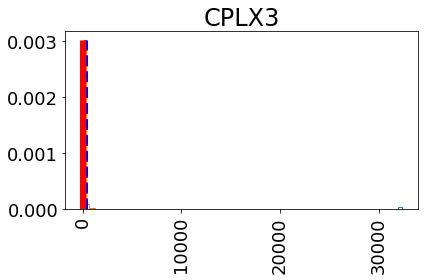

CPM
CPN1
CPN2
CPNE4
CPNE6
CPS1
CPXM1
CR2
CRABP1
CRABP2
CRCT1
CREB3L1
CREB3L3
CREB3L4
CRHBP
CRISP2
CRISP3
CRISPLD1
CRLF1
CRMP1
CRNN
CRP
CRTAC1
CRYAA
CRYBA2
CRYGN
CRYM
CSAG1
CSDC2
CSF3
CSF3R
CSGALNACT1
CSMD3
CSN1S1
CSRP3
CST1
CST2
CST4
CST5
CST6
CSTA
CSTB
CT45A1
CT45A3
CT45A5
CTAG1A
CTAG1B
CTAG2
CTAGE15
CTAGE4
CTB-186H2.3
CTC-554D6.1
CTD-2105E13.6
CTD-2207O23.12
CTD-2228K2.5


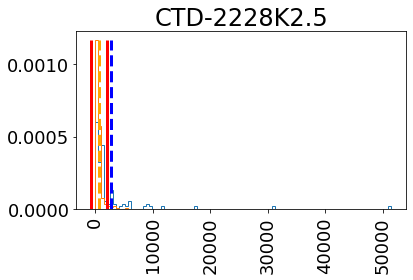

CTD-2545G14.7
CTD-2545M3.6
CTD-3214H19.16
CTH
CTHRC1
CTNNA2
CTRB1
CTRB2
CTSE
CTSG
CTSK
CTSV
CTXN1
CTXN2
CWH43
CX3CL1
CXCL1
CXCL10
CXCL11
CXCL12
CXCL13
CXCL14
CXCL17
CXCL2
CXCL3
CXCL5
CXCL6
CXCL9
CXCR2
CXCR5
CXorf48
CXorf61
CXorf67
CYBB
CYP11B1
CYP17A1
CYP1A1
CYP1B1
CYP24A1
CYP26A1
CYP27A1
CYP2A6
CYP2A7
CYP2B6
CYP2C18
CYP2C8
CYP2C9
CYP2D6
CYP2E1
CYP2F1
CYP2J2
CYP2S1
CYP39A1
CYP3A4
CYP3A43
CYP3A5
CYP3A7
CYP4A11
CYP4A22
CYP4B1
CYP4F11
CYP4F12
CYP4F2
CYP4F22
CYP4F3
CYP4F31P
CYP4X1
CYP4Z1
CYP8B1
CYS1
CYSTM1
CYTL1
DAAM2
DACT3
DAO
DAPK2
DAPL1
DARC
DAW1
DBH
DCC
DCD
DCDC2
DCDC2B
DCSTAMP
DCX
DDC


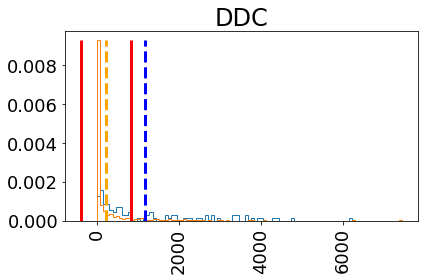

DDIT4L
DEC1
DEFA1
DEFA1B
DEFA5


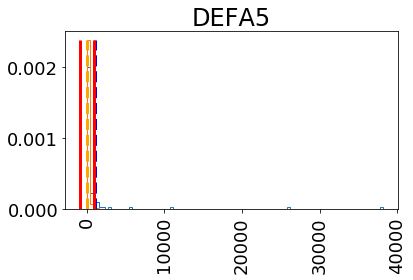

DEFA6


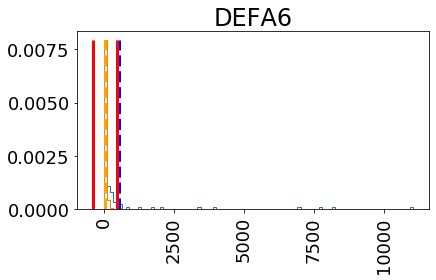

DEFB1
DEFB103A
DEFB103B
DEFB123
DEFB126
DEFB4A
DEFB4B
DEGS2
DEPDC7
DERL3
DGAT2
DGCR6
DGKI
DHODH
DHRS11


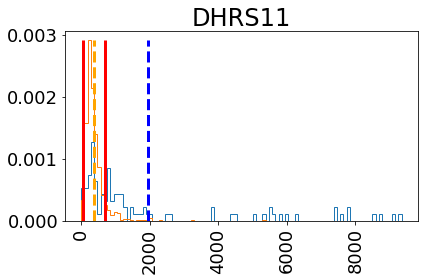

DHRS2
DHRS7C
DHRS9


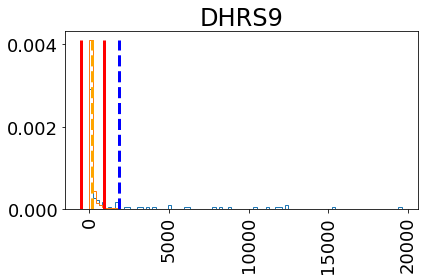

DIO1
DIO2
DKK1
DLC1
DLK1
DLX1
DLX2
DLX3
DLX5
DLX6
DMBT1
DMGDH
DMKN
DMRT1
DMRTA2
DNAH12
DNAH8
DNAH9
DNAJB1
DNAJB5
DNAJC12
DNALI1
DNASE1L3
DNER
DNMT3L
DOK2
DPCR1
DPEP1


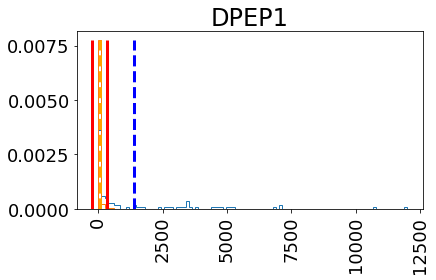

DPEP3
DPP4
DPP6
DPPA4
DPRX
DPT
DPYS
DPYSL5
DRAM1
DRC1
DSC2
DSC3
DSCR8
DSG1
DSG3
DSP
DTX1
DTX4
DUOX1


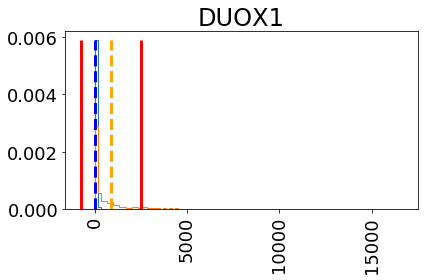

DUOX2
DUOXA1


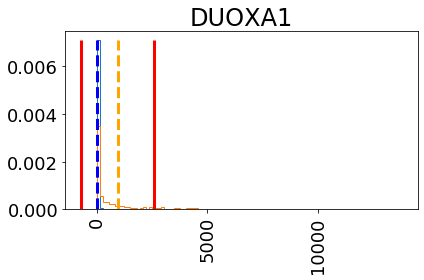

DUOXA2
DUSP13
DUSP26
DUSP27
DUSP4
DUSP9
DYDC2
ECEL1
ECHDC3
ECM1
ECM2
EDN1
EDN2
EDN3
EDNRB
EEF1A2
EFCAB1
EFEMP1
EFHD1
EFNA2


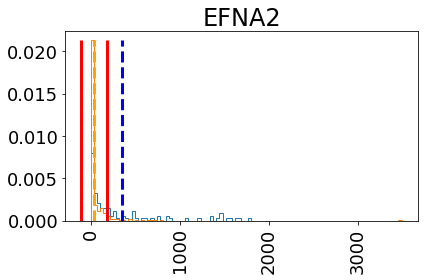

EFNB3
EGFL6
EGLN3
EGR2
EGR3
EGR4
EHF
EHHADH
EIF4E1B
ELAVL3
ELF5
ELOVL2
ELOVL3
ELOVL4
EMID1
EMILIN3
EMP1
EMX2
EN1
ENDOU
ENO3
ENPP2
ENPP3


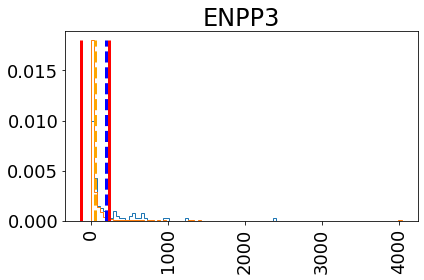

ENPP5
ENTPD5
ENTPD8


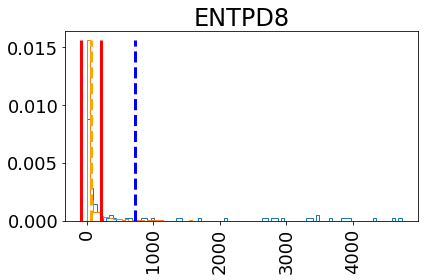

EPGN
EPHA2
EPHA7
EPHA8
EPHX2
EPHX3
EPO
EPS8L1
EPS8L3


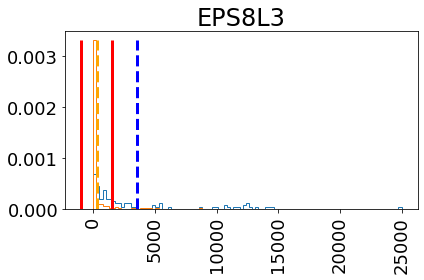

EPYC
ERBB2
EREG
ERG
ERN2


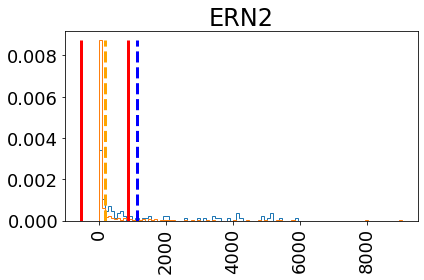

ERO1L
ERVV-1
ERVW-1
ESPL1
ESPN
ESR1
ESRP2
ETNK2
ETNPPL
ETV4
EVA1A
EVPL
EXOC3L4
EYA2
F10
F11
F12
F13A1
F2
F2RL1


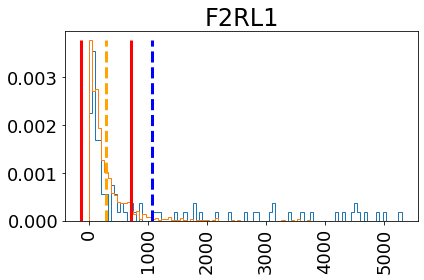

F3
F5
F7
FA2H
FABP1


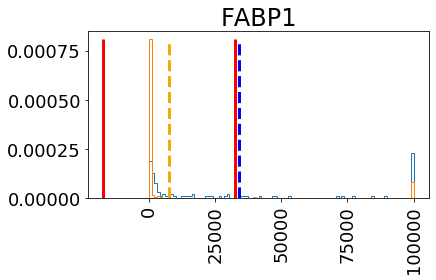

FABP12
FABP3
FABP4
FABP6
FABP7
FABP9
FADS2
FAH
FAM101A
FAM107A
FAM132B
FAM134B
FAM150B
FAM151A
FAM155B
FAM159B
FAM163B
FAM167A
FAM177B
FAM183A
FAM189A2
FAM196A
FAM198B
FAM19A3
FAM19A4
FAM20A


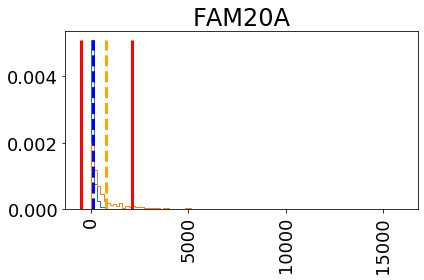

FAM216B
FAM25A
FAM25B
FAM25C
FAM25G
FAM26D
FAM27C
FAM3B
FAM3D


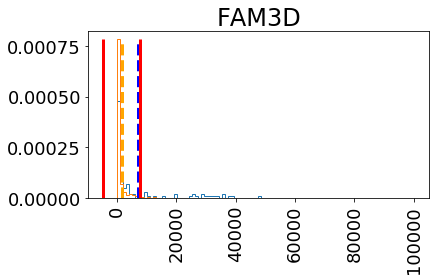

FAM43B
FAM46B
FAM64A
FAM65C
FAM69B
FAM81B
FAM83A
FAM83C
FAM83D
FAM83E


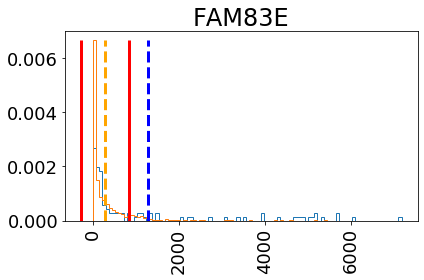

FAM84A


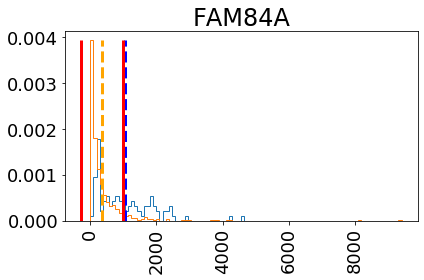

FAM92B
FAM9B
FAM9C
FAP
FAT2
FBP1
FBP2
FBXO40
FCAMR
FCER1G
FCGBP


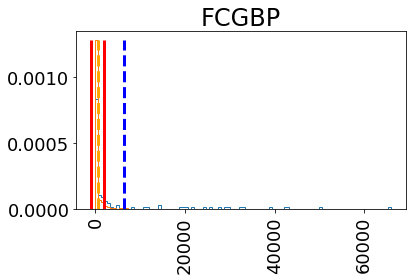

FCGR2A
FCGR2B
FCGR3A
FCN1
FCN2
FCN3
FCRL4
FCRLB
FDCSP
FER1L6
FERMT1


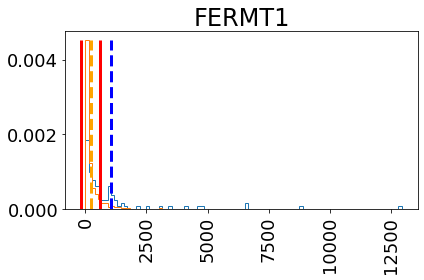

FETUB
FEV
FEZF1
FFAR1
FGA
FGB
FGF10
FGF18
FGF19
FGF21
FGF3
FGF7
FGFBP1
FGFBP2
FGFR2
FGFR3
FGFR4
FGG
FGGY
FGL1
FGL2
FGR
FIGF
FILIP1L
FITM1
FLG
FLG2
FLJ30594
FLNC
FLRT3
FMO2
FMO3
FMO5
FNDC1
FNDC4
FNDC5
FOLH1
FOLR1
FOLR2
FOLR3
FOSB
FOSL1
FOXA1
FOXA2
FOXA3
FOXE1
FOXF1


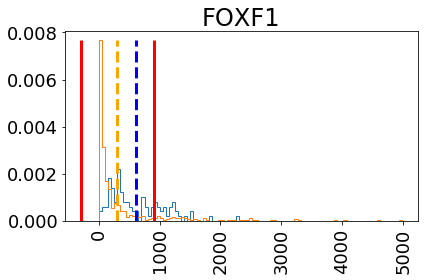

FOXF2
FOXI1
FOXJ1
FOXL2
FOXM1
FOXN1
FOXQ1
FPR1
FREM1
FRG2B
FSCN1
FSD2
FSIP1
FST
FSTL5
FTCD
FUOM
FUT2


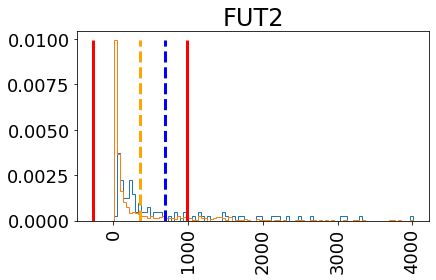

FUT3


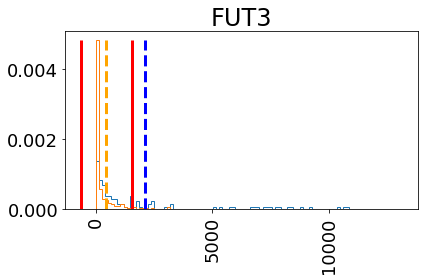

FUT6
FUT9
FXYD1
FXYD2
FXYD4
FXYD6
G0S2
G6PC
GABRA5
GABRB2
GABRE
GABRP
GABRQ
GAD2
GADD45G
GAGE1
GAGE12I
GAGE2D
GAL


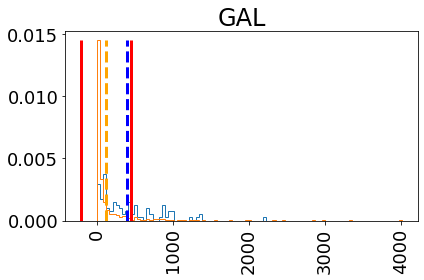

GAL3ST1
GAL3ST3
GALNT6
GALNT8


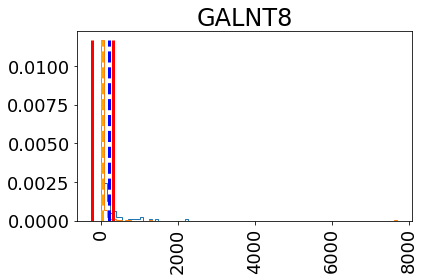

GALNT9
GALR2


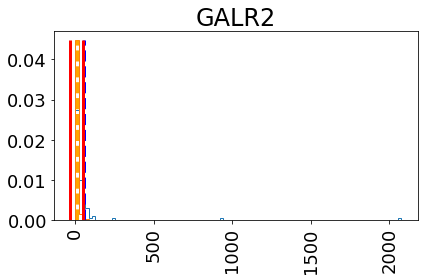

GAMT
GAPDHS
GAS1
GAST
GATA2
GATA3
GATA4
GATM
GBP4
GBP5
GBP6
GBX1
GC
GCG


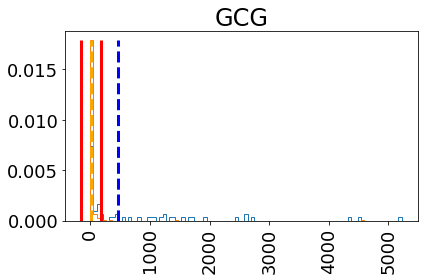

GCGR
GCHFR
GCK
GCKR
GCLC
GCNT3


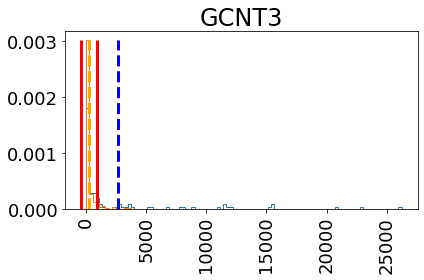

GDA
GDAP1L1


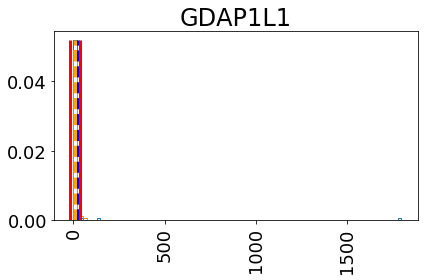

GDF15
GDPD2


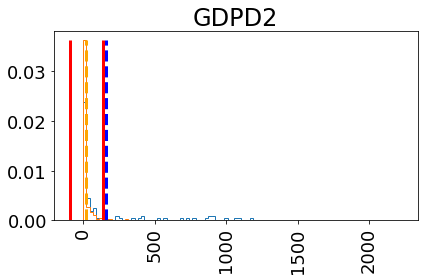

GDPD3
GEM
GFAP
GFRA1
GFRA2
GFRA3
GGH
GGT1
GGT6


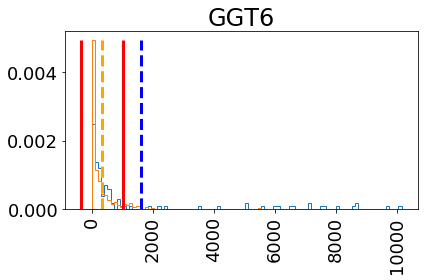

GGTLC3
GHR
GHRH
GHRHR
GHRL
GIF
GIMAP5
GJB1
GJB2
GJB3
GJB5
GJB6
GKN1
GKN2
GLB1L3
GLDC
GLIPR2
GLRA3
GLS2
GLT1D1
GLTP
GLTPD2
GLYAT
GLYATL1
GLYATL2
GLYCTK
GMNC
GMPR
GNA15
GNG11
GNG4
GNLY
GNMT
GNRH2
GOLGA6L9
GOLGA8B
GOLM1
GOLT1A
GP2
GPA33


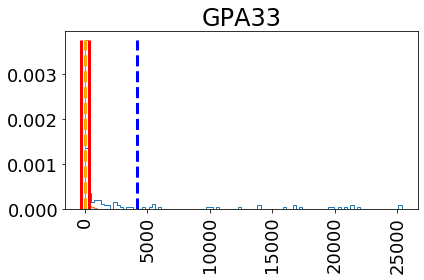

GPAM
GPC3
GPD1
GPIHBP1
GPM6A
GPR110
GPR115
GPR116
GPR124
GPR128
GPR133
GPR15


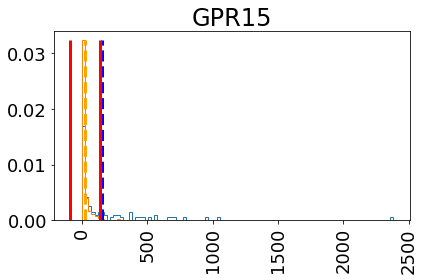

GPR160


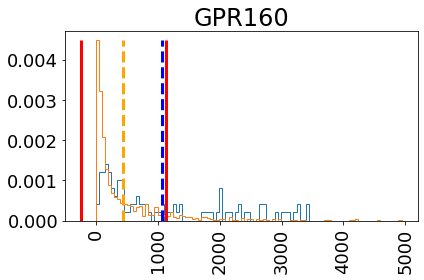

GPR87
GPR88
GPRC5A
GPRC5D
GPT
GPT2
GPX2
GRB14
GRB7
GREB1
GREM1


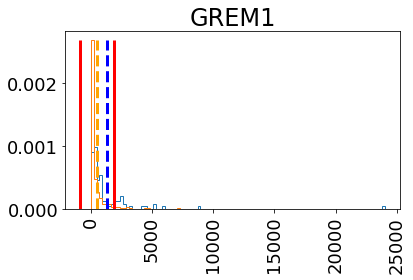

GREM2
GRHL1
GRHL3
GRIA1
GRIA2
GRIN2C
GRIN3A
GRM1
GRP
GRPEL2
GRPR
GSDMA
GSDMB


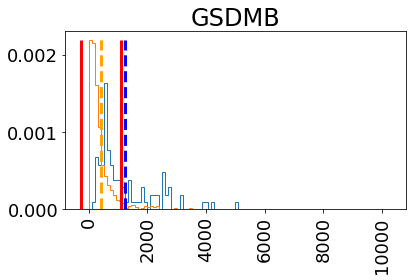

GSDMC
GSTA1
GSTA2
GSTA3
GSTM1
GSTM3
GSTM5
GSTT2
GSTZ1
GSX2
GTSCR1
GTSF1
GUCA2A


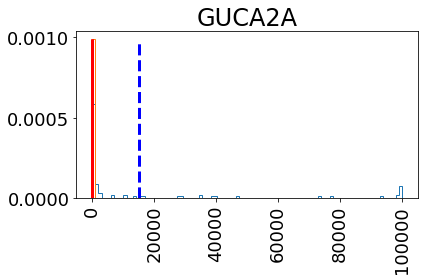

GUCA2B


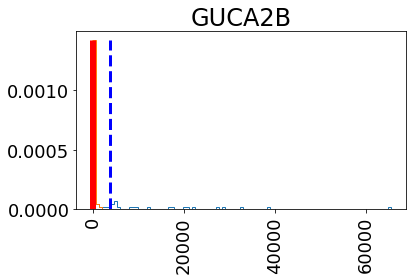

GYG2
GYS2
H2AFB3
HAAO
HABP2
HAL
HAMP
HAND1


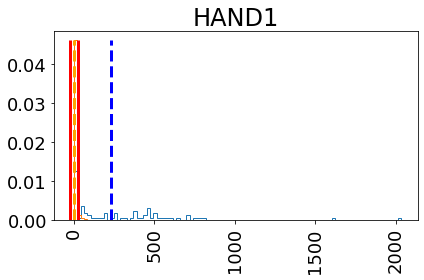

HAND2
HAO1
HAO2
HAS3
HBA1
HBB
HBEGF
HBG2
HBZ
HCAR1
HCAR2
HCAR3
HDC
HEPACAM
HEPACAM2


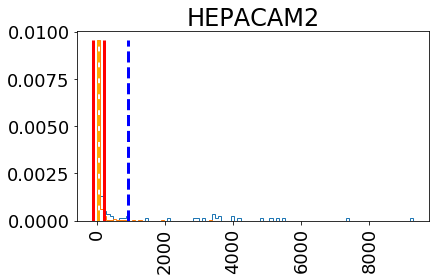

HEPH


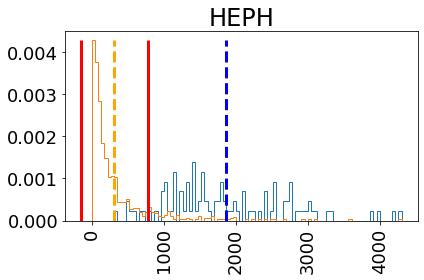

HEPN1
HES2
HES6


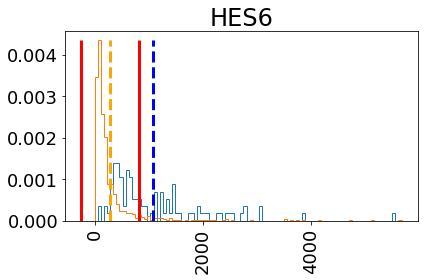

HFE2
HGD
HGF
HGFAC
HHATL
HHEX
HHIP
HHLA2


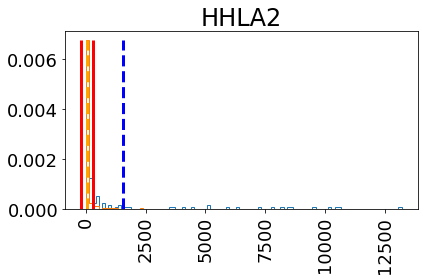

HIF3A
HILPDA
HIST1H1B


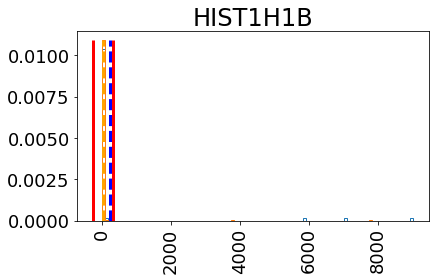

HIST1H1D


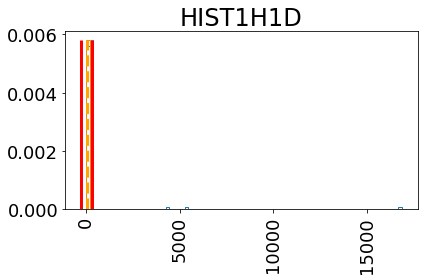

HIST1H1E


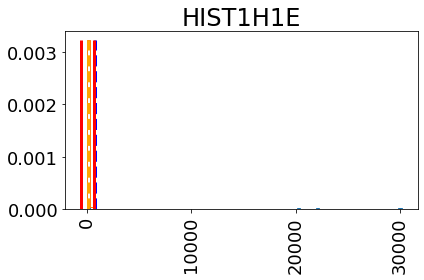

HIST1H2AB


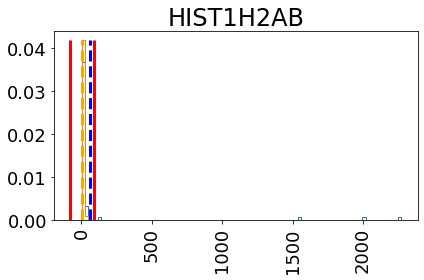

HIST1H2AD


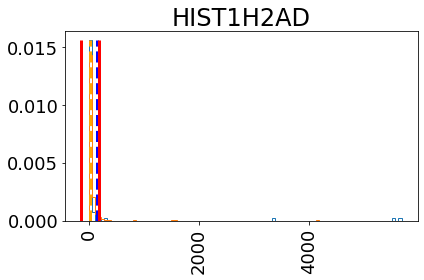

HIST1H2AE
HIST1H2AH


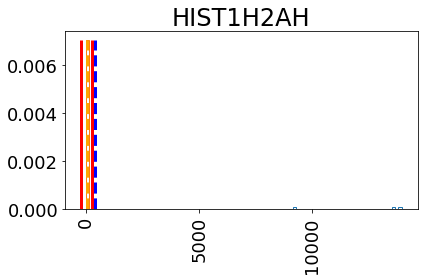

HIST1H2AI
HIST1H2AJ


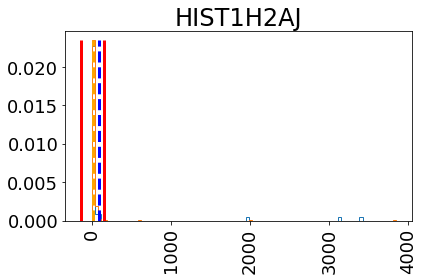

HIST1H2AL
HIST1H2AM


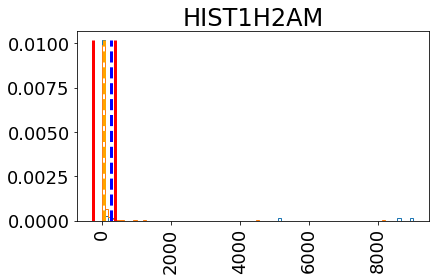

HIST1H2BB
HIST1H2BC
HIST1H2BE
HIST1H2BF
HIST1H2BG


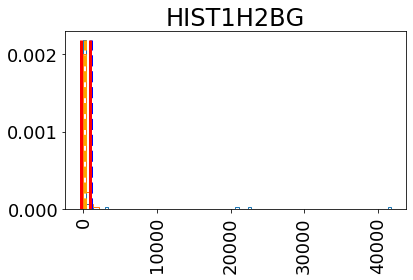

HIST1H2BH


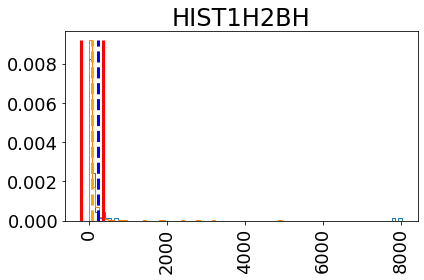

HIST1H2BI


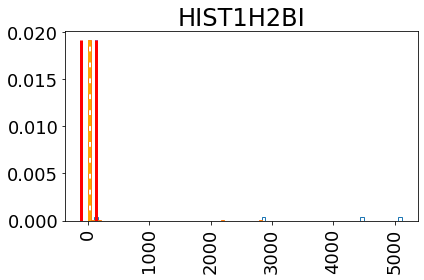

HIST1H2BJ


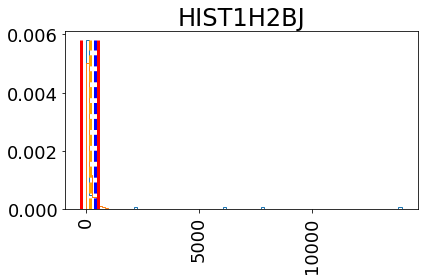

HIST1H2BL


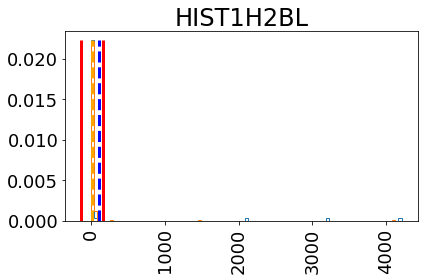

HIST1H2BM
HIST1H2BO
HIST1H3A


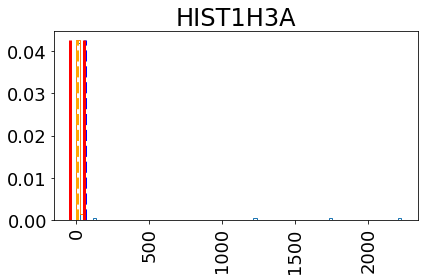

HIST1H3B


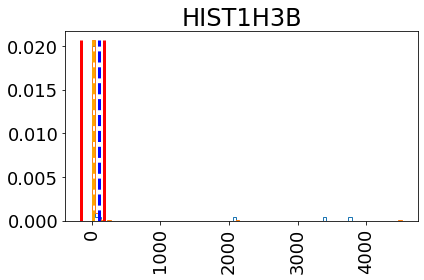

HIST1H3C
HIST1H3D


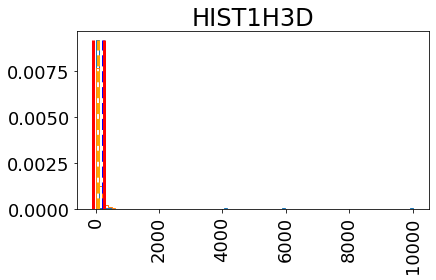

HIST1H3F
HIST1H3G


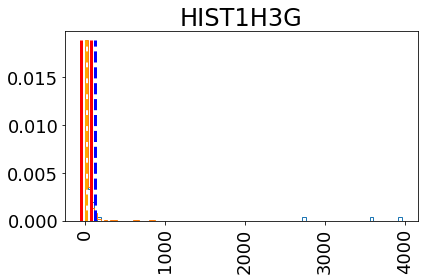

HIST1H3H


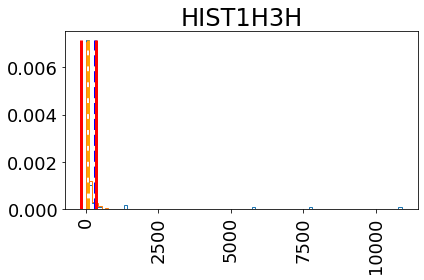

HIST1H3I
HIST1H3J


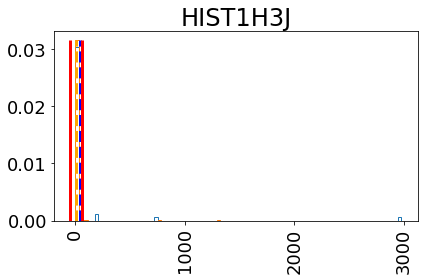

HIST1H4A
HIST1H4B


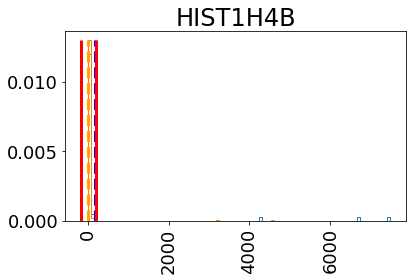

HIST1H4C


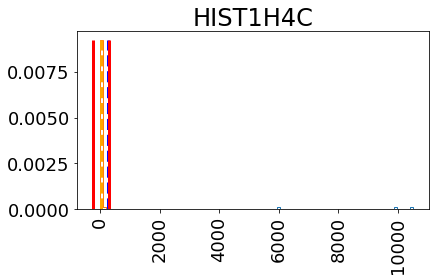

HIST1H4D


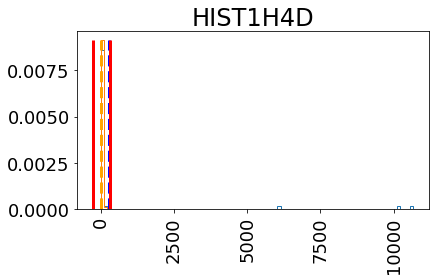

HIST1H4E


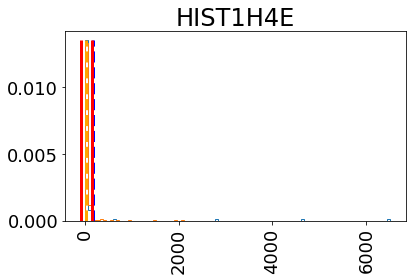

HIST1H4F
HIST1H4H
HIST1H4J


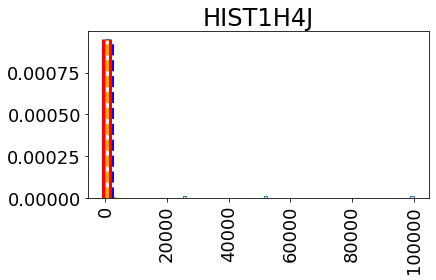

HIST1H4K


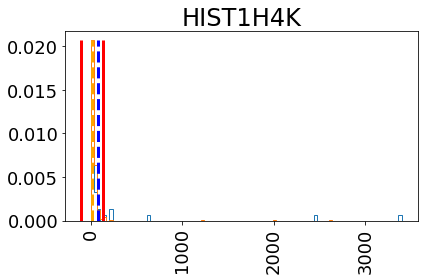

HIST2H2AB
HIST2H2AC
HIST2H2BF
HIST2H3C
HIST2H3D


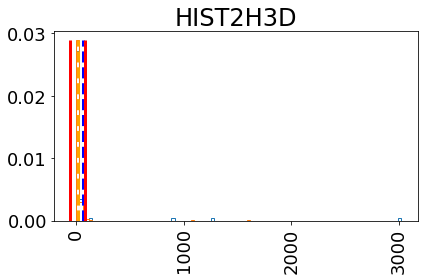

HIST2H4B
HIST3H2BB
HK3
HLA-DMB
HLA-DOA
HLA-DQA1
HLA-DQA2
HLA-DQB1
HLA-DQB2
HLA-DRB5
HLA-G
HLF
HMCN2


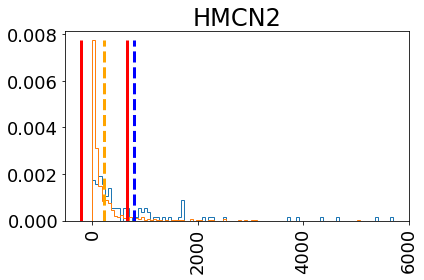

HMGA2
HMGB4


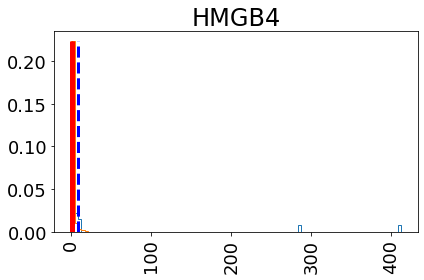

HMGCS1
HMGCS2
HMGN5
HMOX1
HMX1
HNF1B
HNF4A


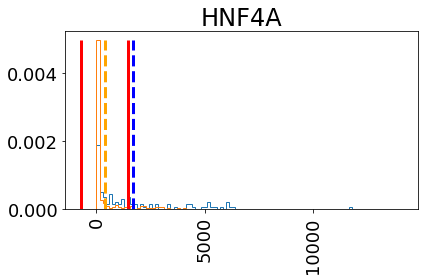

HOGA1
HOPX
HOXA10


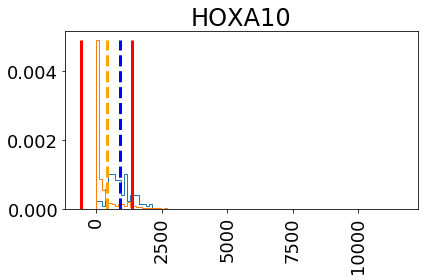

HOXA11
HOXA9


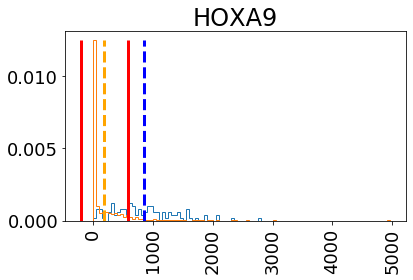

HOXB13
HOXB6


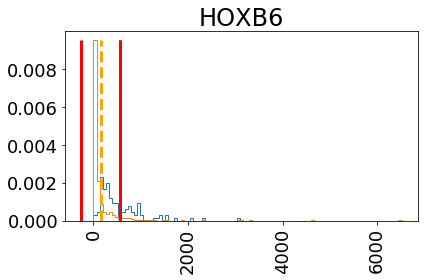

HOXB8
HOXB9


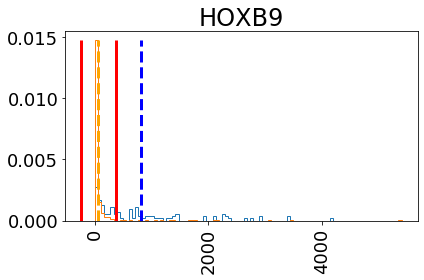

HOXC10
HOXC13
HPD
HPGD
HPN
HPR
HPX
HRASLS
HRASLS2


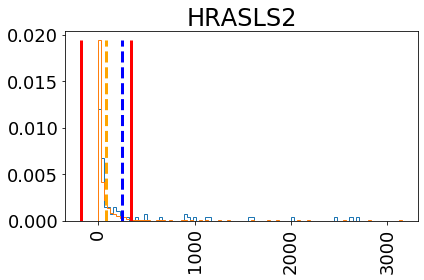

HRASLS5
HRC
HRG
HRH3


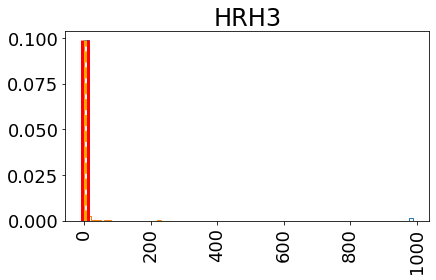

HRNR
HRSP12
HS3ST1
HS3ST6
HSD11B1
HSD11B2


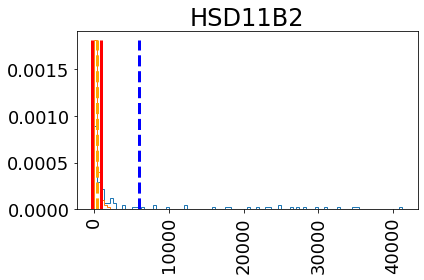

HSD17B13
HSD17B2
HSD17B6
HSD3B1
HSD3B2


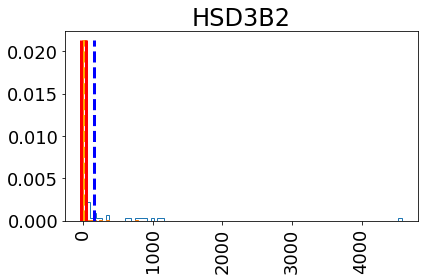

HSPA1B
HSPA6
HSPB3
HSPB6
HSPB7
HSPB8
HTR2B
HTR3A
HTR3B
HUS1B
HYAL1
IAPP
IBSP
ICAM1
ICAM4
ID4
IDO1
IFFO2
IFI44L
IFIT3
IGF1
IGF2
IGFALS
IGFBP1
IGFL1
IGFL2
IGFL3
IGFN1
IGLL5


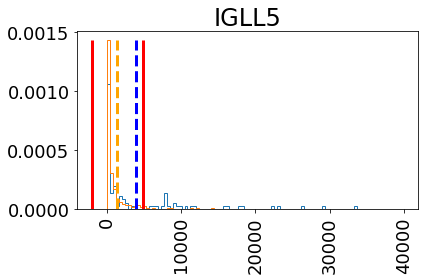

IGSF1
IGSF10
IGSF23
IHH
IL17B
IL17F
IL17REL
IL18
IL1A
IL1B
IL1R2
IL1RAP
IL1RL1
IL1RN
IL20RB
IL21
IL24
IL27
IL2RG


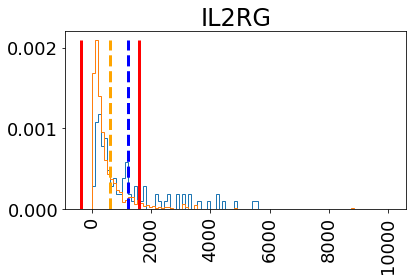

IL33
IL36B
IL36G
IL36RN
IL37
IL6
IL6ST
IL7R
IL8
IMPG2
INHBA
INHBB
INHBC
INHBE
INMT
INPP5J
INS
INSIG1
INSL5


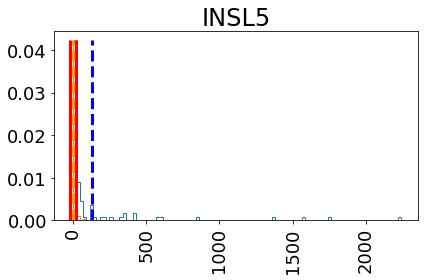

INSL6
INSM1
IPCEF1
IQSEC3
IRX1
IRX2
ISG15
ISM1
ISM2
ISYNA1
ITGA8
ITGB2
ITGB6
ITIH1
ITIH2
ITIH3
ITIH4
ITIH5
ITLN1


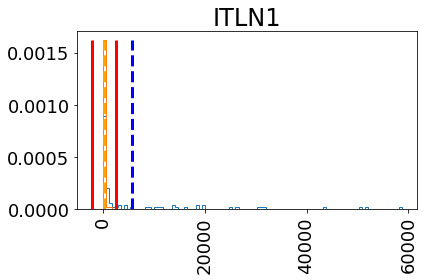

ITLN2
ITM2A
IVL
IYD
JPH2
KAZALD1
KCNAB1
KCNC2
KCNE2
KCNE3
KCNE4
KCNG1
KCNH2
KCNIP2
KCNJ15


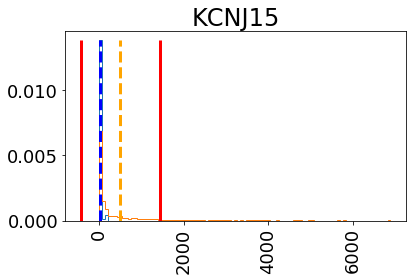

KCNJ16
KCNJ3
KCNJ4
KCNK3
KCNK7
KCNMA1
KCNMB1
KCNN4
KCNQ1
KCNQ2
KCNU1
KDM8
KHDC1L
KHK
KIAA0101
KIAA1199


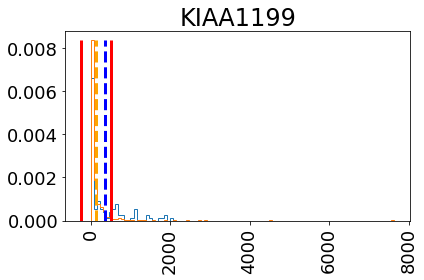

KIAA1324
KIAA1456
KIAA1467
KIF12
KIT
KLB
KLC3
KLF15
KLF4
KLF5
KLHDC7B
KLHDC8A
KLHL41
KLK1


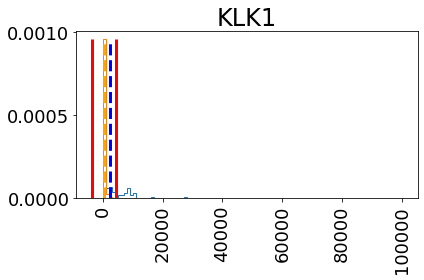

KLK10
KLK11
KLK12
KLK13
KLK14
KLK2
KLK3
KLK4
KLK5
KLK6
KLK7
KLK8
KLKB1
KLRF2
KMO
KNG1
KNSTRN
KPRP
KREMEN2
KRT1
KRT10
KRT13
KRT14
KRT15
KRT16
KRT2
KRT20


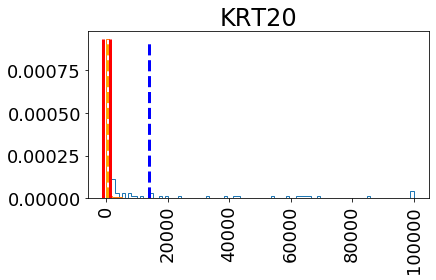

KRT23
KRT24
KRT25
KRT27
KRT31
KRT34
KRT36
KRT39
KRT40
KRT6A
KRT6B
KRT6C
KRT73
KRT75
KRT77
KRT78
KRT79
KRT80
KRT81
KRT83
KRT85
KRT86
KRT9
KRTAP1-1
KRTAP1-3
KRTAP1-5
KRTAP11-1
KRTAP2-3
KRTAP21-2
KRTAP3-1
KRTAP3-2
KRTAP3-3
KRTAP5-10
KRTAP5-2
KRTAP5-7
KRTAP5-8
KRTDAP
KYNU
L1CAM


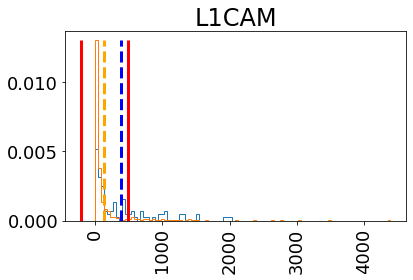

LAD1
LAIR1
LAMA1
LAMA3
LAMB3
LAMC2
LAMP3
LAPTM5
LBP
LBX1
LCAT
LCE1A
LCE1B
LCE1C
LCE1D
LCE1F
LCE2A
LCE2B
LCE2C
LCE2D
LCE3D
LCE3E
LCE5A
LCE6A
LCN1
LCN12
LCN15


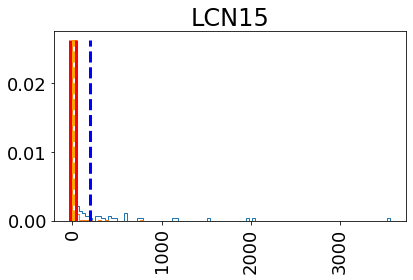

LCN6
LDB3
LDHD
LDLRAD1
LDLRAD4
LDOC1


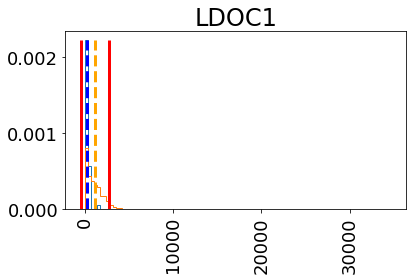

LEAP2
LECT1
LECT2
LEFTY1


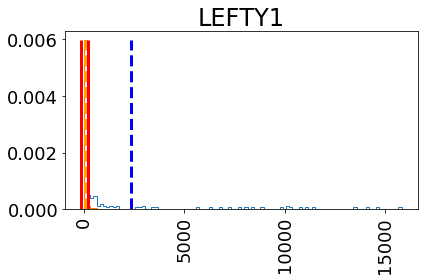

LEFTY2
LEP
LEPR
LEPREL1
LGALS12
LGALS14
LGALS2


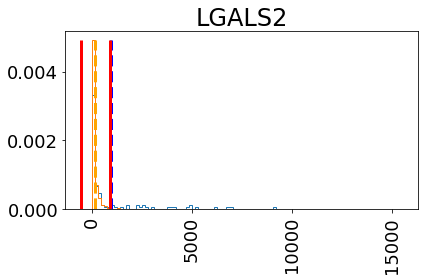

LGALS4


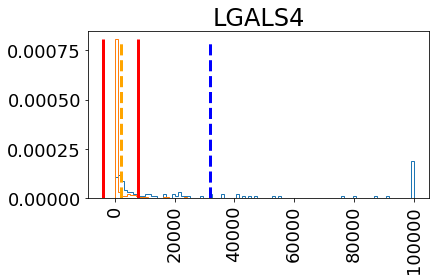

LGALS7
LGALS7B
LGALS9B


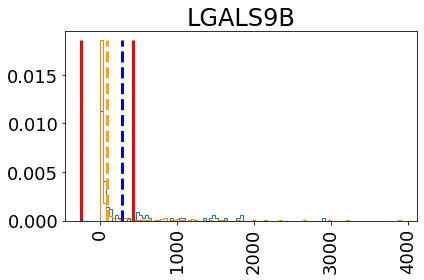

LGALS9C


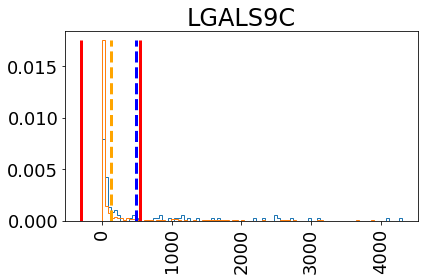

LGALSL
LGI2
LGI3
LGR5
LHX1
LHX2
LHX3
LHX8
LHX9
LIMCH1


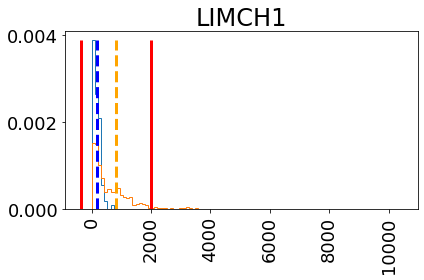

LIME1
LIPC
LIPE
LIPF
LIPG
LIPH


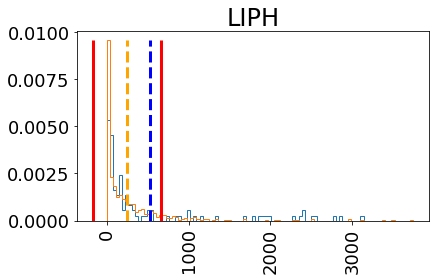

LMAN1L
LMO3
LMOD1
LMOD3
LMX1A
LOR
LOXL4
LPA
LPCAT1
LPIN2
LPL
LPO
LPP
LRG1
LRP1B
LRP2
LRP4
LRRC15
LRRC17
LRRC19


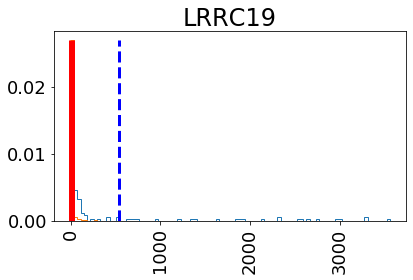

LRRC26
LRRC36
LRRC4
LRRC9
LRRK2
LRRN1
LRRN4
LRRTM1
LRRTM3
LST1
LST3
LTB
LTB4R
LTB4R2
LTF
LY6D
LY6G6C
LY6G6D


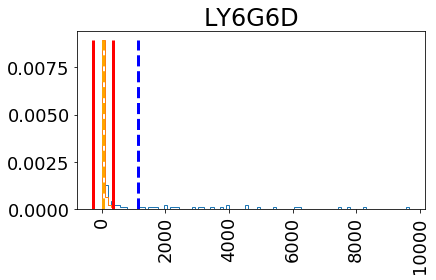

LY6H
LY6K
LYG2
LYNX1
LYPD1
LYPD2
LYPD3
LYPD5
LYPD6B
LYPD8


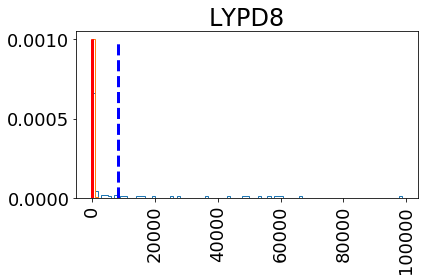

LYVE1
MAB21L2


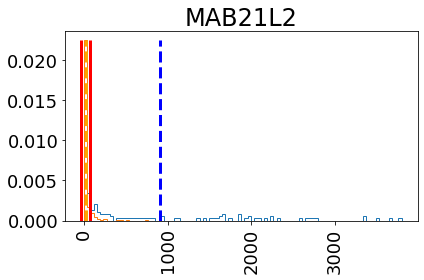

MAB21L3
MACC1
MAEL
MAFA
MAGEA1
MAGEA10
MAGEA2B
MAGEA3
MAGEA4
MAGEA6
MAGEA8
MAGEA9
MAGEB17


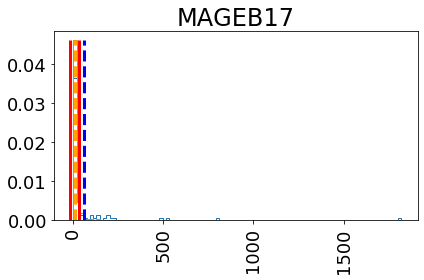

MAGEB2
MAGEC1
MAGEC2
MAGED4
MAGED4B
MAL
MAL2
MALL
MAMDC2
MAOB
MAP3K19
MAPT
MARC2
MARCH4
MARCO
MASP1
MASP2
MAT1A
MATN1
MATN2
MATN4
MB
MC4R
MCF2
MDFI
MECOM
MEIS1
MEIS3
MEOX1
MEOX2
MEP1A


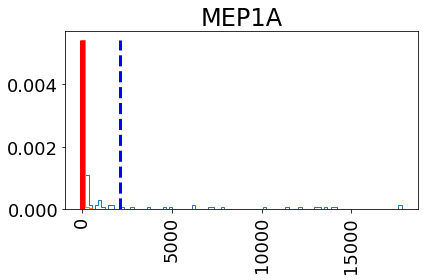

MEP1B


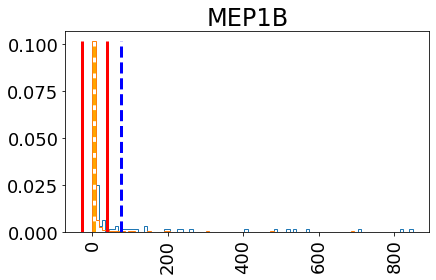

MEPE
MESP1
MEST
MET
METTL7B
MFAP2
MFAP5
MFGE8
MFSD2A
MFSD4
MIA
MIEN1
MIOX
MISP


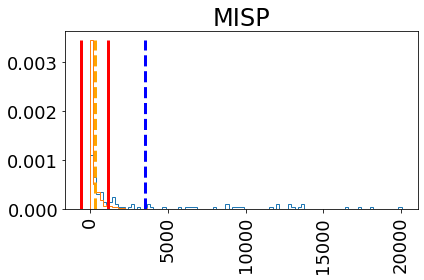

MLIP
MLNR
MLPH
MLXIPL
MME
MMP1
MMP10
MMP11
MMP13
MMP19
MMP20
MMP28
MMP3
MMP7
MMP8
MMP9
MOGAT2


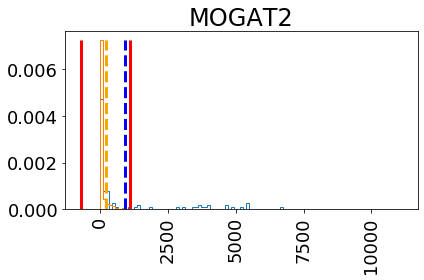

MORN5
MPPED1
MPPED2
MPV17L
MRAP
MRAS
MRC1
MRC1L1
MRGPRF
MROH2A
MRVI1
MS4A1
MS4A12


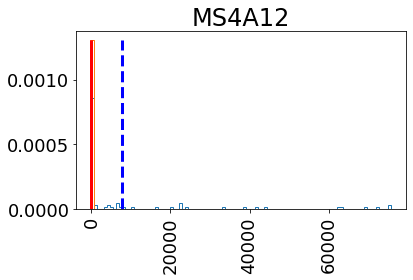

MS4A15
MS4A4A
MS4A7
MS4A8
MSC
MSLN
MSLNL
MSMB
MSMO1
MSMP
MSR1
MSRB3
MST1
MSX1
MSX2
MT1A
MT1B
MT1E
MT1F
MT1G
MT1H
MT1M
MT3


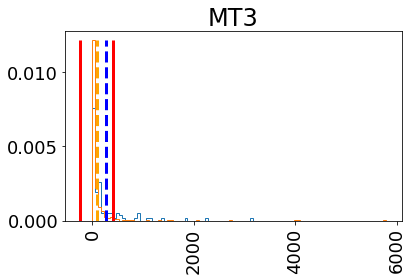

MT4
MTHFS
MTMR11


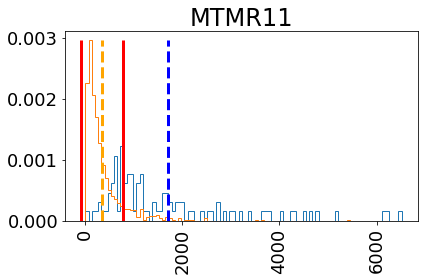

MTNR1A
MTRNR2L2
MTRNR2L9
MTTP
MUC12


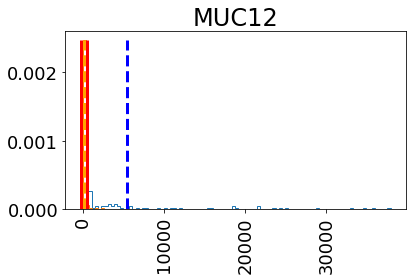

MUC13


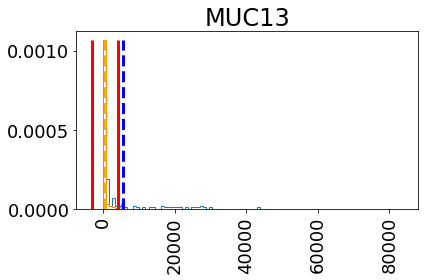

MUC15
MUC16
MUC17
MUC19
MUC2


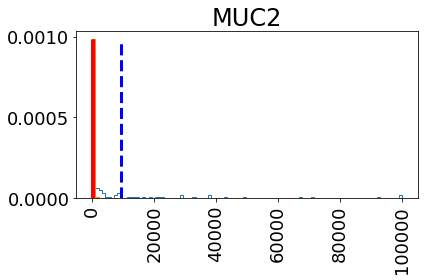

MUC20


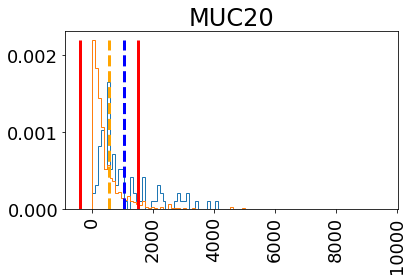

MUC21
MUC3A


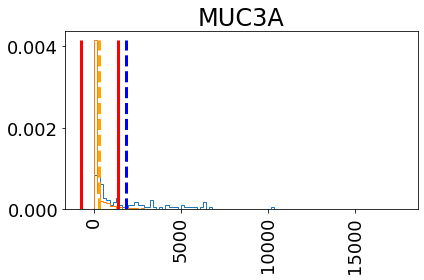

MUC4


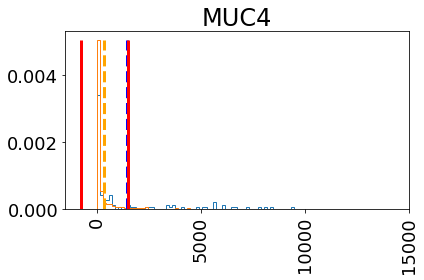

MUC5AC
MUC5B
MUC6
MUC7
MUCL1
MURC
MUSTN1
MX1
MX2
MXD1
MYBL2
MYBPC1
MYBPC2
MYBPH
MYBPHL
MYCL
MYEOV
MYF6
MYH1
MYH13
MYH2
MYH3
MYH6
MYH7
MYH7B
MYL1
MYL2
MYL3
MYL4
MYL7
MYLK2
MYLK3
MYLPF
MYO18B
MYO1A


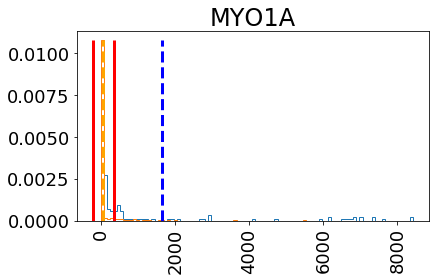

MYO1G
MYO7B


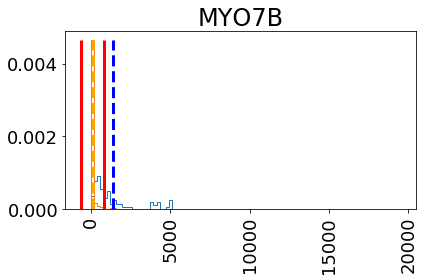

MYOC
MYOCD
MYOM1
MYOM2
MYOM3
MYOT
MYOZ1
MYOZ2
MYOZ3
MYPN
MYRF
MYT1
MYT1L


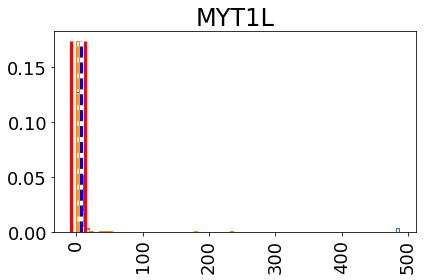

MYZAP
MZB1
NAA11
NADK2
NAGS
NAPSA
NAT1
NAT2
NAT8
NAT8L
NBPF4
NCALD
NCAM1
NCAN
NCAPD3
NCCRP1
NCF2
NDN
NDNF
NDP
NDRG4
NDUFA4L2
NDUFC2-KCTD14
NEB
NECAB2
NEDD4L
NEDD9
NEFH
NEFM
NEK10
NELL2
NES
NEU4


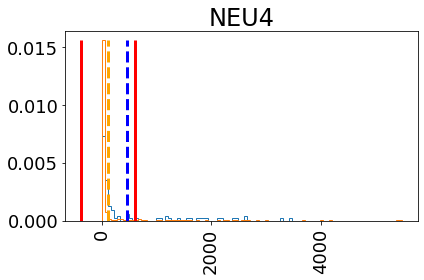

NEXN
NGB
NGFR
NHLH2
NINJ2
NIPAL4
NKAIN1
NKAIN3
NKAIN4
NKD1


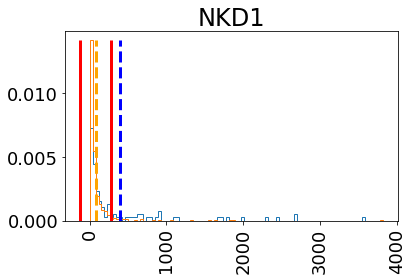

NKD2
NKG7
NKX2-1
NKX2-2
NKX2-5
NKX3-1
NKX6-1
NKX6-2
NKX6-3
NLRP4
NLRP7
NMB
NMRK2
NMU
NNAT
NNMT
NOSTRIN
NOTUM
NOV
NOX1


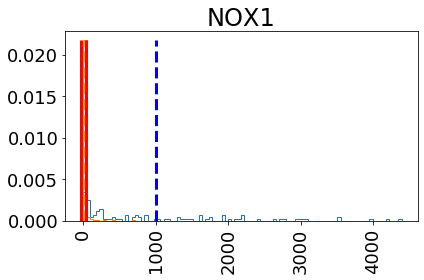

NOXO1


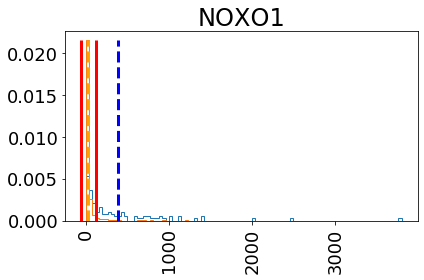

NPC1L1
NPHS1
NPHS2


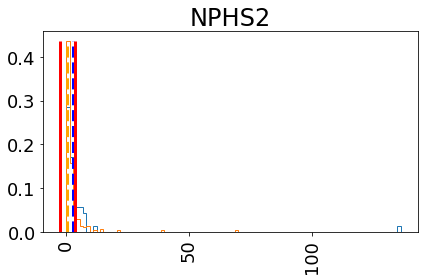

NPNT
NPPB
NPPC
NPR1
NPTX1
NPTX2
NPW
NPY
NPY1R
NPY5R
NR0B1
NR0B2
NR1H4
NR1I2


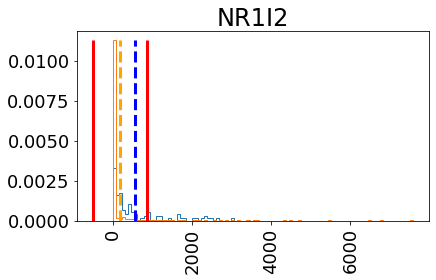

NR1I3
NR2F1
NR4A2
NR4A3
NR5A1
NRAP
NRG1
NRGN
NRIP3
NRN1
NRXN2
NSG1
NSG2
NT5C1A
NT5E
NTN1
NTN4
NTRK2
NTS
NTSR2
NUAK2
NUDT10
NUDT8
NUP210L
NXF2
NXF2B
NXNL2
NXPE1


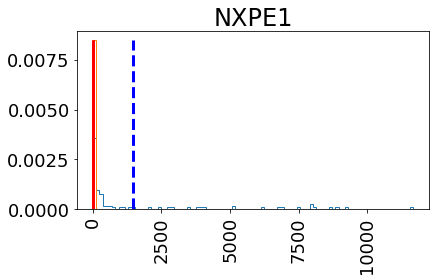

NXPE4


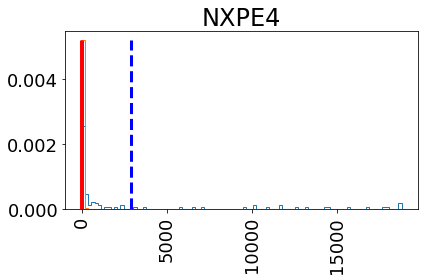

NXPH1
NXPH2
OAF
OASL
OBP2A
ODAM
OFCC1
OGDHL
OGN
OIT3
OLAH
OLFM1
OLFM2


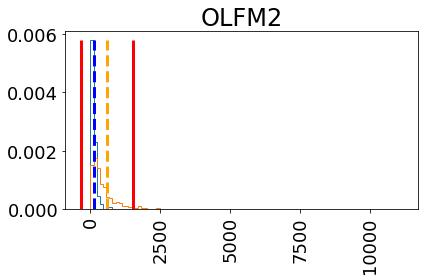

OLFM4


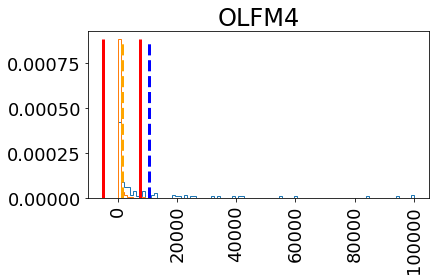

OLFML3
OLR1
OMG
ONECUT1
OPRK1
OR51E1
OR51E2
ORM1
ORM2
OSCAR
OSGIN1
OSR1
OSR2
OSTN
OTC
OTOG
OTOS
OTX2
OVOL1
OXT
OXTR
PADI1
PADI2


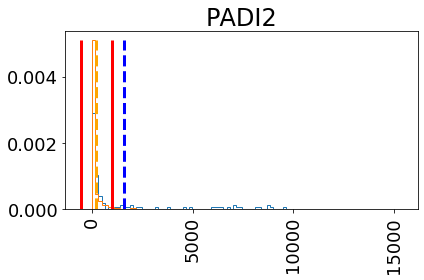

PADI3
PAEP
PAGE1
PAGE2
PAGE2B
PAGE4
PAGE5
PAH
PALM
PALMD


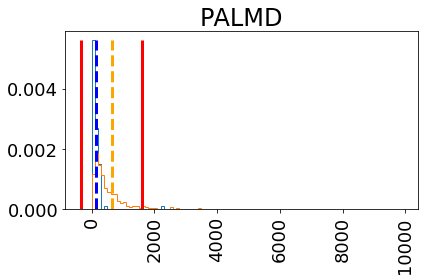

PAMR1
PAPPA2
PAPSS2


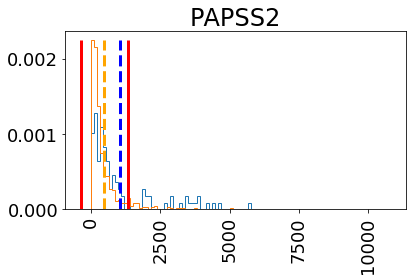

PAQR9
PASK
PAX1
PAX2
PAX6
PAX7
PAX8
PAX9
PBLD
PBX4
PC
PCDH19
PCDHGA8
PCDP1
PCK1
PCK2
PCOLCE
PCOLCE2
PCP4
PCP4L1
PCSK1
PCSK1N
PCSK2
PCSK6
PCSK9
PDCL2
PDE2A
PDE4C


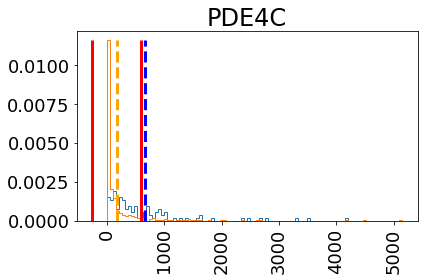

PDE4DIP
PDE8B
PDE9A


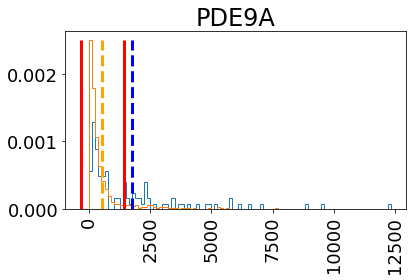

PDGFRA
PDIA2
PDLIM3
PDPN
PDX1
PDZD3


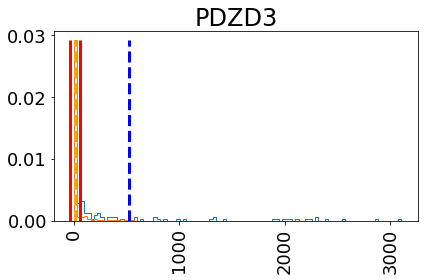

PDZK1
PDZK1IP1
PEBP4
PECR
PEG10
PEG3
PENK
PEX10
PEX5L
PF4
PFKFB1
PGA3
PGA4
PGA5
PGAM2
PGC
PGF
PGLYRP2
PGLYRP4
PGM5
PGR
PHACTR3
PHGR1


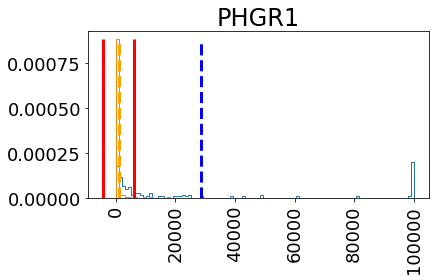

PHKG1
PHLDA2
PHYH
PHYHD1


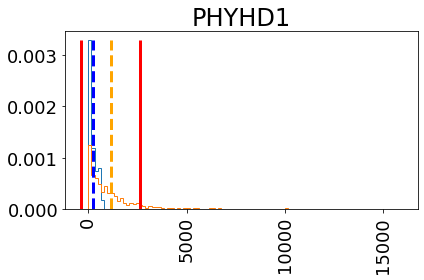

PI15
PI16
PI3
PIFO
PIGR


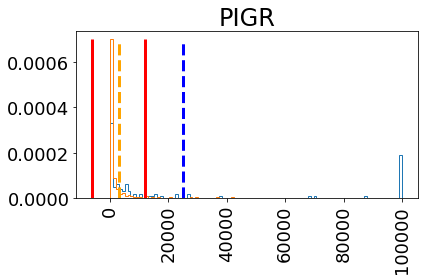

PIGY
PIK3AP1
PIM2
PIP
PIPOX
PITX1
PITX2
PIWIL1
PKDCC
PKHD1L1
PKIA
PKIB


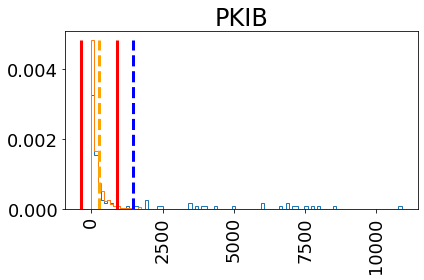

PKLR
PKNOX2
PKP1
PKP3
PLA1A
PLA2G10


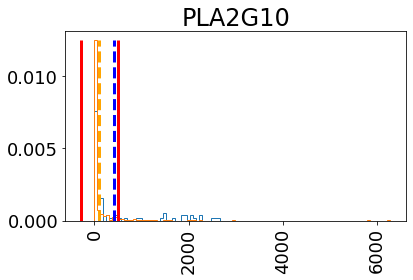

PLA2G1B
PLA2G2F
PLA2G3
PLA2G4D
PLA2G4E
PLA2G4F
PLA2G7
PLA2R1
PLAC8


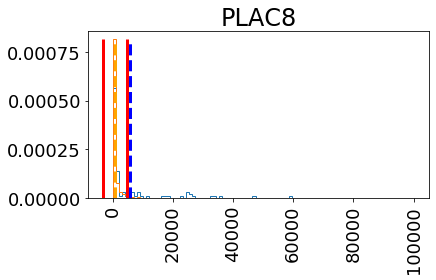

PLAC9
PLAT
PLAU
PLCXD2
PLEK2


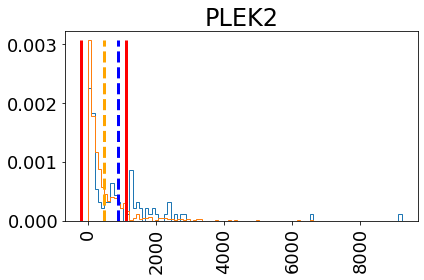

PLEKHG6
PLEKHH1
PLEKHN1
PLEKHS1
PLG
PLGLB1
PLGLB2
PLIN1
PLIN2
PLIN4
PLIN5
PLLP
PLN
PLP1


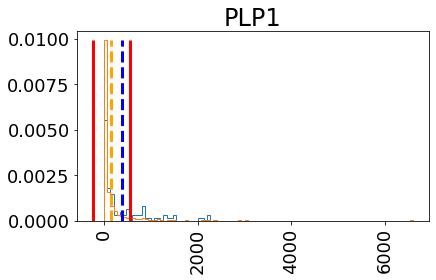

PLS1


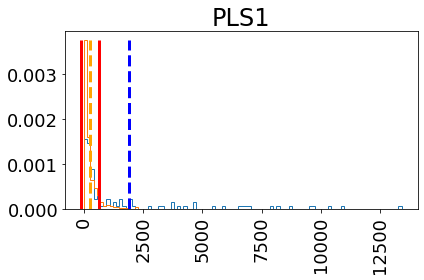

PM20D1
PMEL
PMEPA1
PNCK
PNLDC1
PNLIP
PNLIPRP3
PNMA5
PNMAL1
PNMT
PNOC
POF1B
POMC
PON1
PON3
POPDC2
POSTN
POTEM
POU2AF1
POU3F2
POU3F3
PPARG


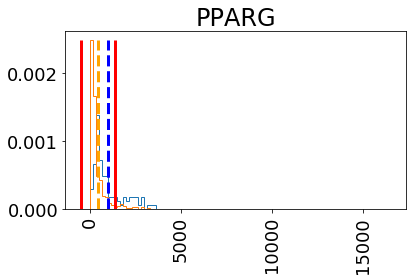

PPARGC1A
PPBP
PPL
PPP1R12B
PPP1R14A
PPP1R14C
PPP1R14D


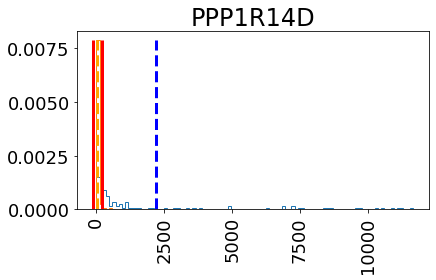

PPP1R1A
PPP1R1B
PPP1R27
PPP1R3C
PPP1R3G
PPP2R2C
PPY
PRAC1
PRAME
PRAP1
PRB2
PRB3
PRB4
PRELP
PRG4
PRH1
PRH2
PRIMA1
PRKAG3
PRKAR2B
PRL
PROC
PROCR
PRODH
PRODH2
PROK1
PROM1


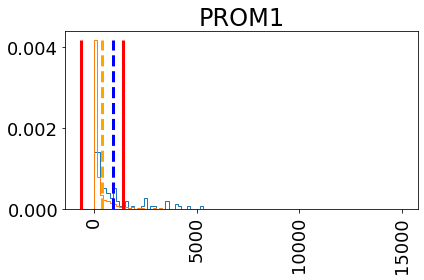

PROS1
PROX1
PROZ
PRPH


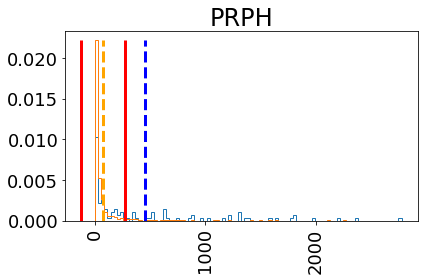

PRR15


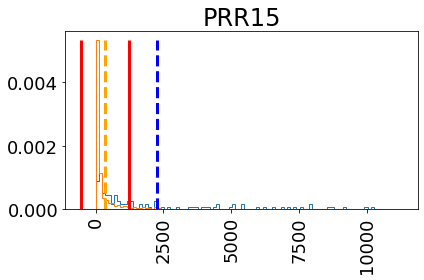

PRR15L


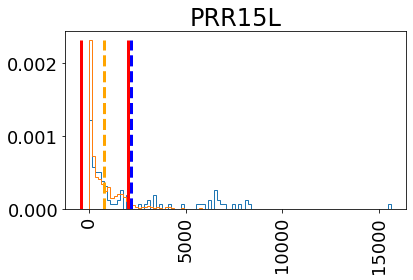

PRR4
PRSS1
PRSS21
PRSS22
PRSS27
PRSS3
PRSS56
PRUNE2
PSAPL1
PSAT1
PSCA
PSD
PSG1
PSG4
PSG5
PSG9
PSORS1C2
PSPN
PTGER3
PTGES
PTGIS
PTGR1
PTGS1


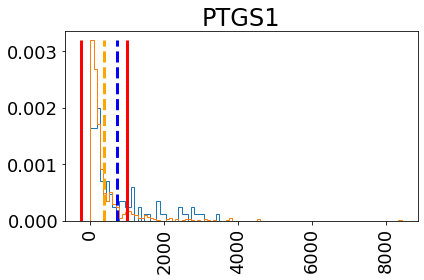

PTGS2
PTH
PTH1R
PTHLH
PTK6
PTN
PTPRC
PTPRH


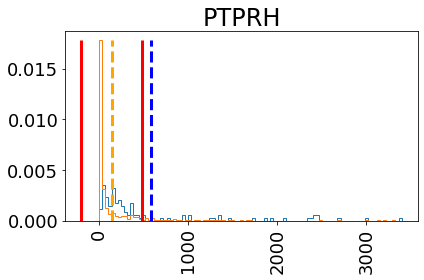

PTPRN
PTPRZ1
PTX3
PVALB
PVRL1
PVRL4
PXDC1
PXMP2
PYDC1
PYDC2
PYGM
PYY


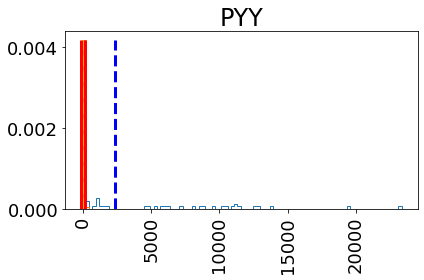

PZP
QPRT
RAB17
RAB26
RAB38
RAD51AP1
RAET1E
RAET1G
RAET1L
RAG2
RAI2
RAMP1
RAP1GAP
RAPGEF3
RAPGEFL1
RAPSN
RARRES1
RASD1
RASD2
RASGRF1
RASL11B
RASL12
RBFOX3
RBM24
RBP1
RBP2
RBP4
RBP5
RBP7
RBPMS2
RCAN1
RCAN2
RCL1
RDH11
RDH12
RDH16
RDH5
REC8
REEP6
REG1A
REG1B


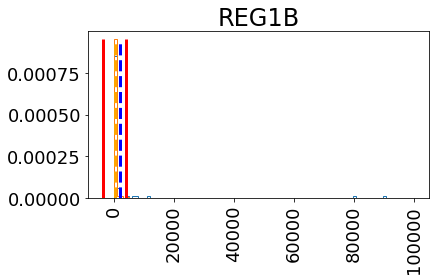

REG3A
REG3G
REG4


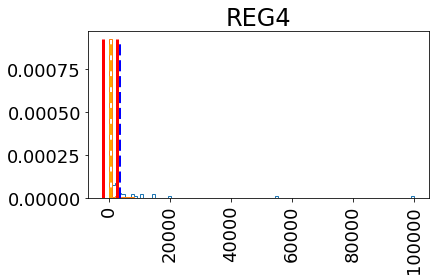

RELN
REN
REP15


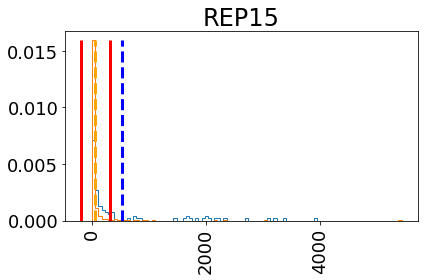

RERG
RERGL
RET
RETN
RETNLB


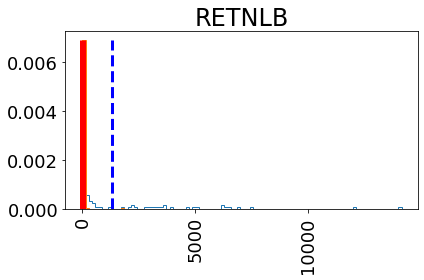

RFPL2
RGCC
RGL3
RGMA
RGN
RGS16
RGS5
RGSL1
RHAG
RHBG
RHCG
RHOBTB2
RHOD
RHOV
RHOXF2
RHOXF2B
RHPN2


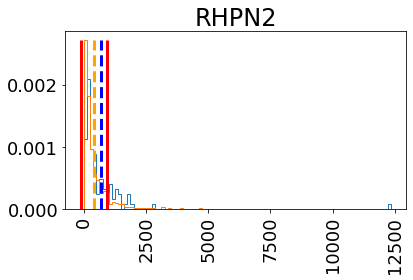

RIMS4
RIPPLY1
RLBP1
RLN1
RLN2
RNASE7
RND1
RNF17


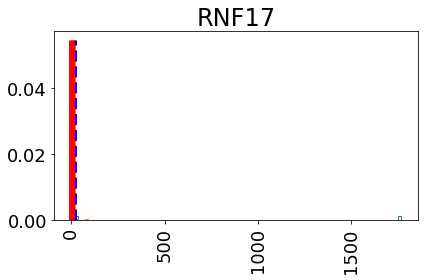

RNF186


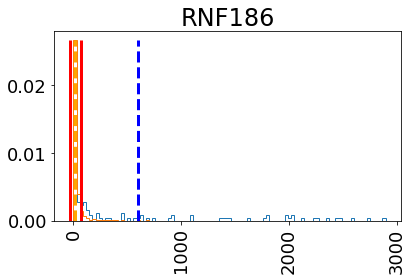

RNF212
RNF223
RNF43


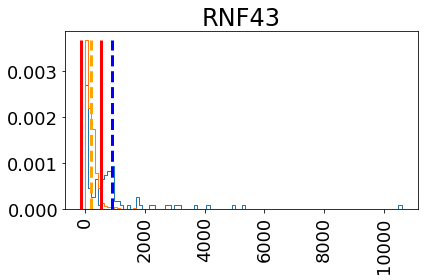

ROPN1
ROPN1B
ROPN1L
RORC
ROS1
RP11-155D18.14
RP11-190A12.7
RP11-201K10.3
RP11-343C2.9
RP11-362K2.2
RP11-463D19.2
RP11-512M8.5
RP11-598P20.5
RP11-599B13.6
RP11-603J24.9
RP11-664D7.4
RP11-685N3.1
RP11-766F14.2
RP11-77K12.7


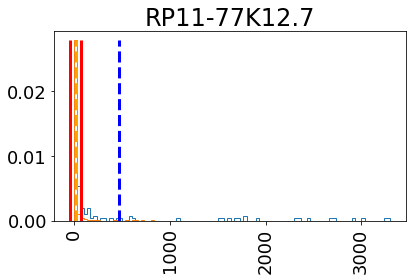

RP11-886H22.1
RP4-583P15.14
RP5-966M1.6
RPL3L
RPRM
RRAD
RRM2
RSAD2
RSC1A1
RSPH1
RSPO1
RSPO3
RSPO4
RTKN2
RTN1
RTN4RL2
RTP3
RXRG
RYR1
S100A1
S100A12
S100A3
S100A7
S100A7A
S100A8
S100B
S100P
S1PR1
SAA1
SAA2
SAA4
SAGE1
SALL1
SAMD11
SAMD9
SARDH
SATB2


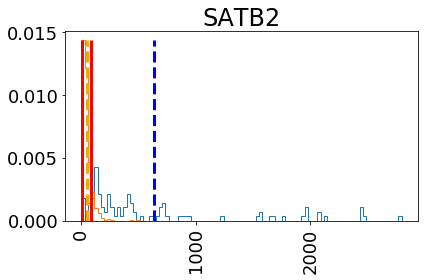

SBK2
SBP1


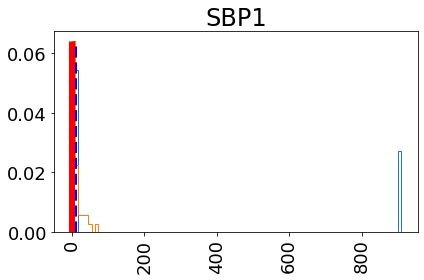

SBSN
SCARA3
SCARA5
SCARB1
SCD
SCEL
SCG3
SCG5
SCGB1A1
SCGB1C1
SCGB1D2
SCGB2A1
SCGB2A2
SCGB3A1
SCGB3A2
SCGN


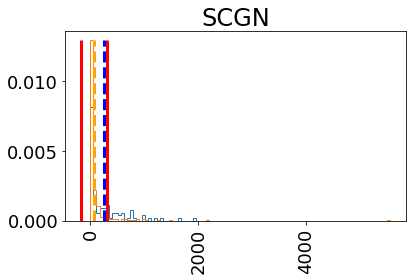

SCNN1B


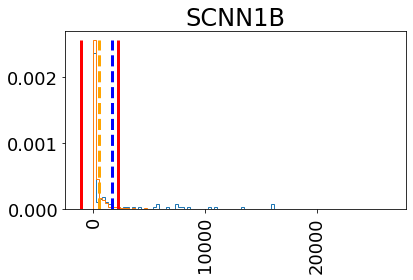

SCRT1


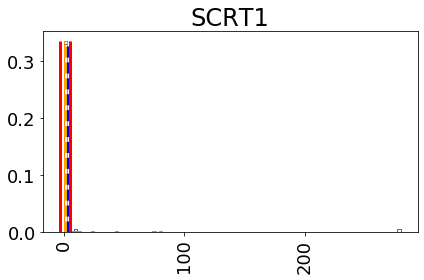

SCTR
SCUBE2
SCUBE3
SCXA
SDCBP2


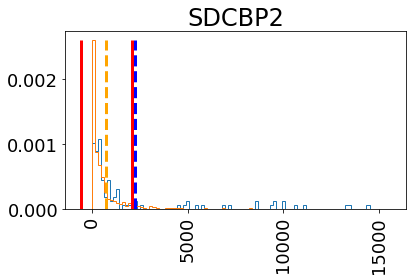

SDPR
SDR16C5
SDR9C7
SDS
SDSL
SEC14L2
SEC14L6
SECTM1


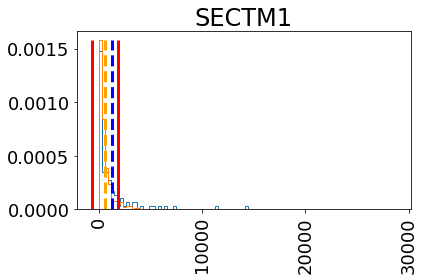

SELE
SELV
SEMA3C
SEMA3D
SEMA3G
SEMG1
SEMG2
SEPT1
SEPT5
SERHL2
SERPINA1
SERPINA10
SERPINA11
SERPINA12
SERPINA4
SERPINA5
SERPINA6
SERPINA7
SERPINA9
SERPINB1
SERPINB10
SERPINB13
SERPINB2
SERPINB3
SERPINB4
SERPINB5
SERPINB7
SERPINC1
SERPIND1
SERPINE1
SERPINE2
SERPINF2
SERPINI1
SEZ6
SEZ6L
SFRP1
SFRP2
SFRP4
SFRP5
SFTA2
SFTA3
SFTPA1
SFTPA2
SFTPB
SFTPC
SFTPD
SGCA
SGK2


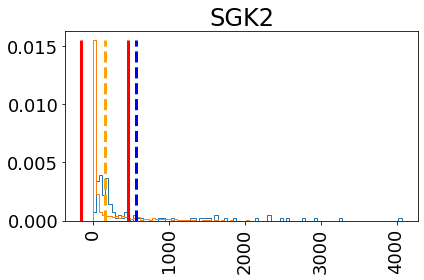

SHBG
SHD


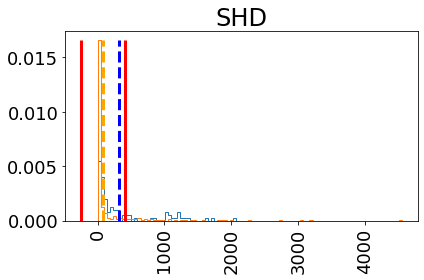

SHISA2
SHMT1
SIRPB1
SIX2
SIX3
SKAP1
SLC10A1
SLC10A4
SLC11A1
SLC12A3
SLC13A2


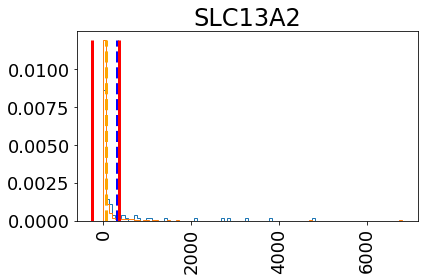

SLC13A3
SLC13A4
SLC13A5
SLC14A1
SLC15A3
SLC17A3
SLC17A9
SLC18A1
SLC19A3
SLC1A1
SLC1A2
SLC1A6
SLC22A1
SLC22A10
SLC22A11
SLC22A18AS


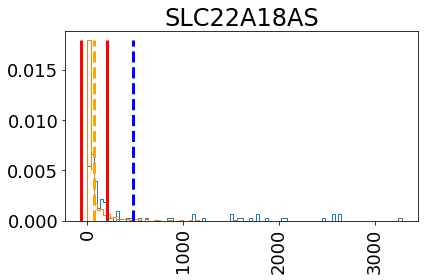

SLC22A3
SLC22A31
SLC22A7
SLC24A3
SLC25A15
SLC25A18
SLC25A29
SLC25A47
SLC26A2


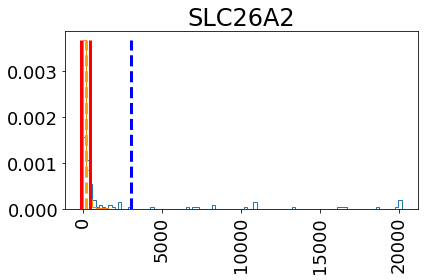

SLC26A3


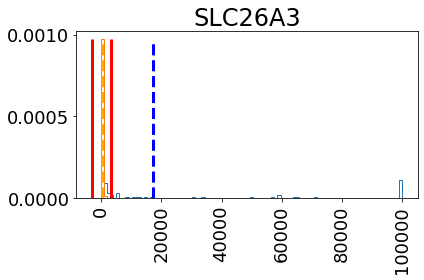

SLC26A4
SLC26A7
SLC26A9
SLC27A2
SLC27A5
SLC28A1
SLC28A2
SLC2A1
SLC2A2
SLC2A3
SLC2A4
SLC2A5
SLC30A10
SLC30A2
SLC30A4
SLC30A8
SLC34A2
SLC36A2
SLC38A11
SLC38A4
SLC39A2
SLC39A5


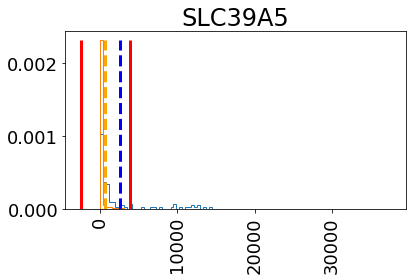

SLC39A6
SLC39A8
SLC3A1
SLC43A1
SLC44A4


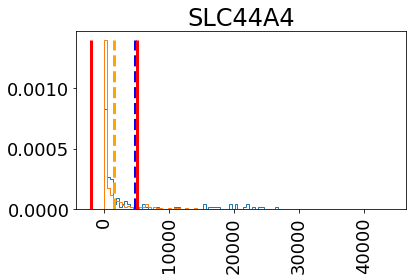

SLC45A2
SLC45A3
SLC46A2
SLC46A3
SLC47A1
SLC4A10
SLC4A11
SLC4A4
SLC4A5
SLC51A
SLC51B


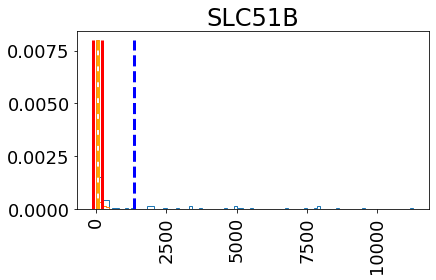

SLC5A5
SLC5A8
SLC6A1
SLC6A11
SLC6A12
SLC6A14
SLC6A15
SLC6A4
SLC7A10
SLC7A14


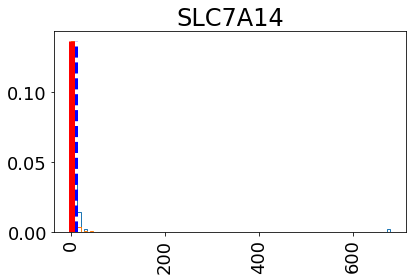

SLC7A2
SLC7A3
SLC7A4
SLC7A5
SLC9A3


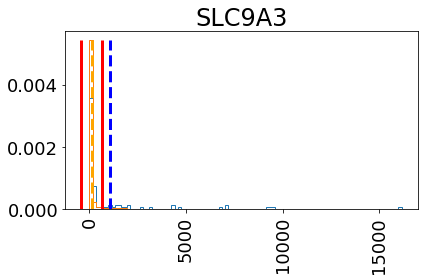

SLC9A4
SLCO1B3
SLCO2B1
SLN
SLURP1
SMAGP
SMCP
SMIM22


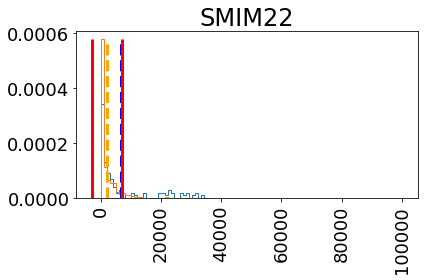

SMIM5
SMIM6
SMOC1
SMOC2
SMPX
SMTNL1
SMTNL2
SNAI2
SNCAIP
SNCG
SNTG1
SNTN
SNX22
SNX31
SOHLH1
SORBS1
SORBS2
SOST
SOSTDC1
SOWAHA


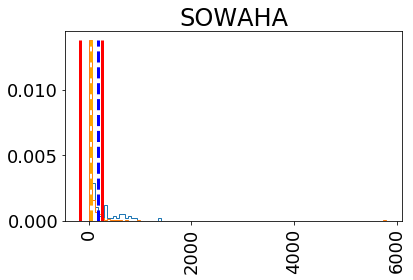

SOX10
SOX15
SOX17
SOX2
SOX21
SP7
SP9
SPAG11A
SPAG11B
SPAG17
SPAG6
SPANXB1
SPANXB2
SPANXC
SPANXD
SPATS1
SPDEF
SPEG
SPI1
SPIB


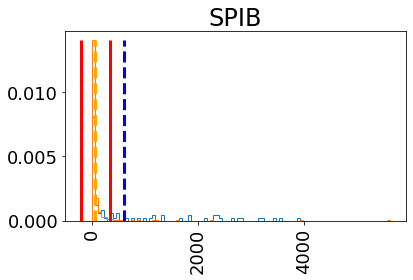

SPIC
SPINK1
SPINK13
SPINK2
SPINK4


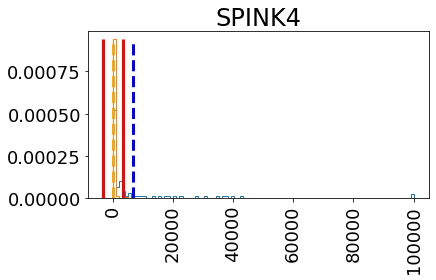

SPINK5
SPINK6
SPINK7
SPINK8
SPINK9
SPN
SPNS2
SPOCD1
SPOCK1
SPOCK2
SPOCK3
SPON2
SPP1
SPP2
SPRR1A
SPRR1B
SPRR2A
SPRR2B
SPRR2D
SPRR2E
SPRR2F
SPRR2G
SPRR4
SPTBN2
SPTSSB
SRL
SRPX
SST
SSX1
SSX2
SSX2B
SSX4B
SSX5
ST3GAL5


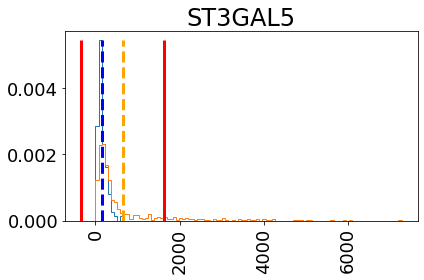

ST6GAL1
ST6GALNAC1


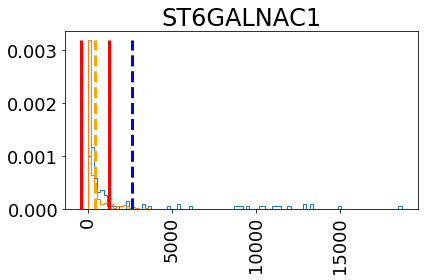

ST8SIA3
STAC2
STAC3
STATH
STC1
STC2
STEAP1
STEAP2
STEAP3
STEAP4
STK32B
STMN2


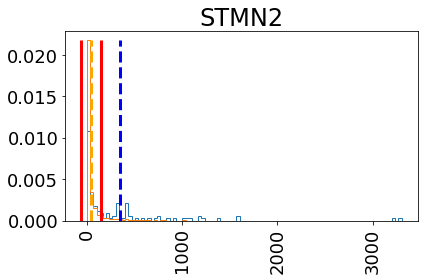

STOML3
STRA6
SULT1A1
SULT1A2
SULT1B1


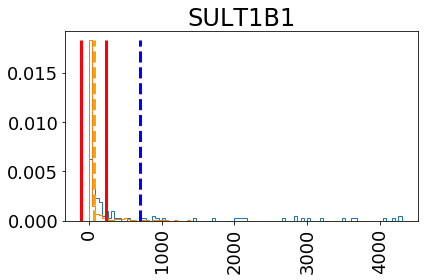

SULT1C2
SULT1E1
SULT2A1
SULT2B1
SUN3
SUSD2
SUSD3
SUSD4
SYCN


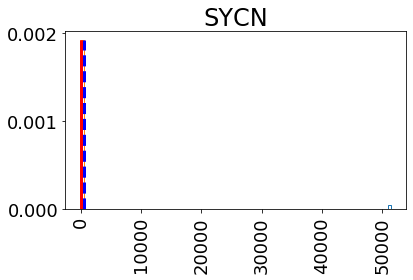

SYCP1
SYNGR4
SYNM
SYNPO2
SYNPO2L
SYNPR
SYT12
SYT13
SYT4
SYT7
SYT8
SYTL2


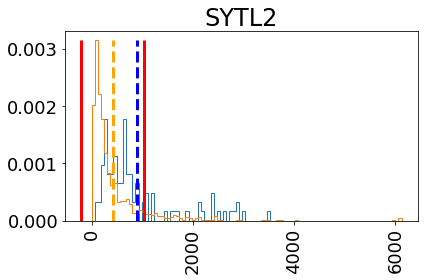

TAAR1
TAC1
TAC3
TAC4
TACR2


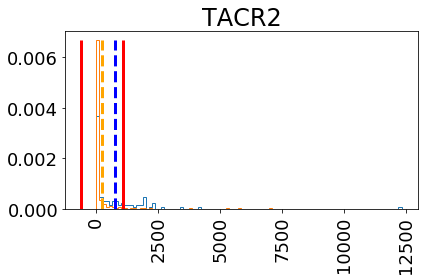

TACSTD2


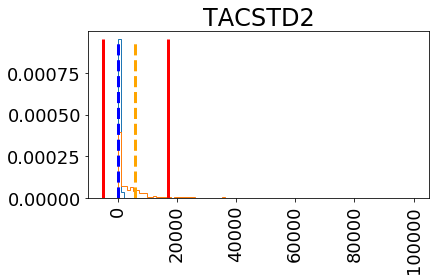

TAT
TBC1D9
TBX10


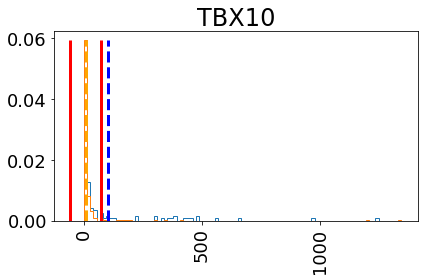

TBX15
TBX4
TCAP
TCEAL2
TCEAL7
TCERG1L
TCF21
TCF24
TCHH
TCL1A
TCN1
TCP10L
TDO2
TDRD12
TDRD9
TECTB
TEKT1
TERT
TESC
TEX101
TEX37
TF
TFAP2A
TFF1
TFF2
TFPI
TFPI2
TFR2
TFRC
TG
TGFB3
TGFBR3
TGM1
TGM3
TGM4
TGM5
TGM7
THBD
THBS2
THBS4
THEM5
THRSP
TIMP4
TJP3


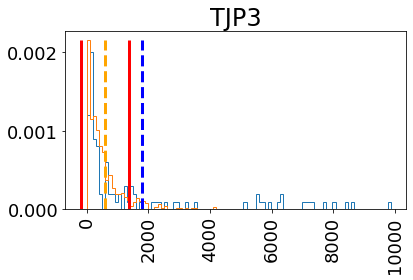

TKTL1
TM4SF19
TM4SF4
TM4SF5
TM6SF2
TMC1
TMC3
TMC5
TMED6
TMEFF2
TMEM100
TMEM101
TMEM108
TMEM114
TMEM125
TMEM132C
TMEM139
TMEM14E
TMEM154
TMEM163
TMEM171


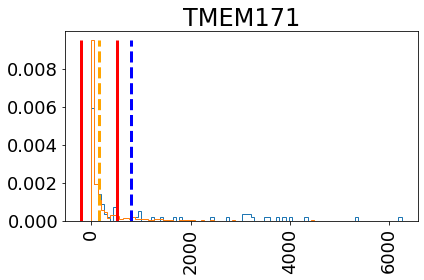

TMEM176A
TMEM176B
TMEM178A
TMEM184A
TMEM189-UBE2V1
TMEM190
TMEM213
TMEM236


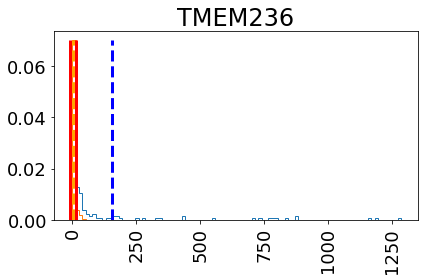

TMEM27
TMEM40
TMEM45A
TMEM45B


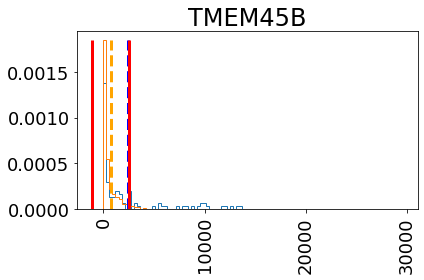

TMEM52B
TMEM79
TMEM82
TMEM8C
TMEM92
TMOD1
TMOD4
TMPRSS11A
TMPRSS11B
TMPRSS11D
TMPRSS11E
TMPRSS13
TMPRSS2
TMPRSS3
TMPRSS4


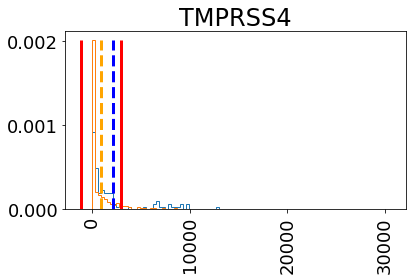

TMPRSS6
TMSB15A
TNC
TNFAIP8L3
TNFRSF11B
TNFRSF19
TNFRSF6B
TNFSF4
TNMD
TNNC1
TNNC2
TNNI1
TNNI2
TNNT1
TNNT2
TNNT3
TNP1
TNS4
TNXB
TOP2A
TP53AIP1
TP63
TPH1
TPO
TPPP2
TPPP3
TPRG1
TPRXL
TPSAB1
TPSG1


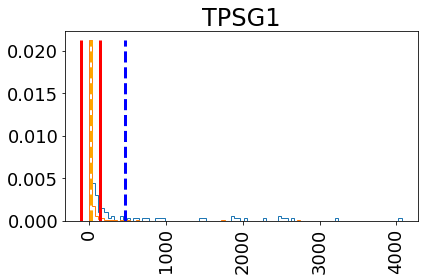

TPTE
TPX2
TRABD2A


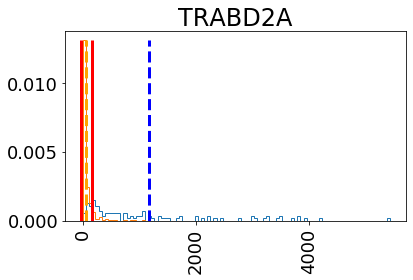

TRDN
TREM1
TRH
TRIM15


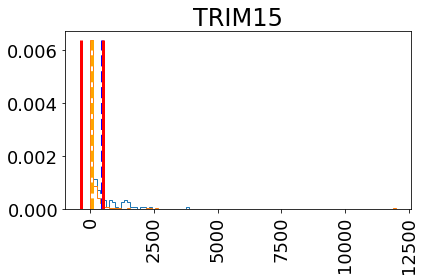

TRIM29
TRIM31


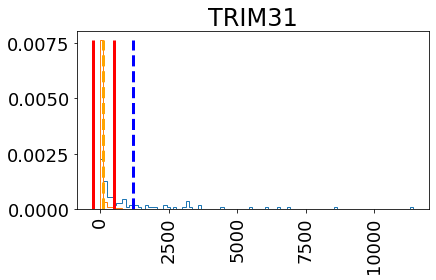

TRIM50
TRIM54
TRIM55
TRIM63
TRIM72
TRIML2
TRNP1
TRPM4


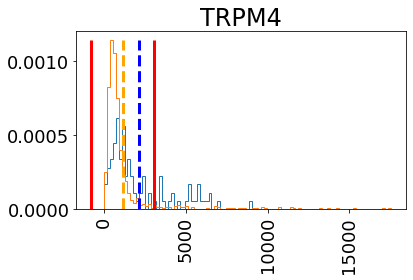

TRPM6


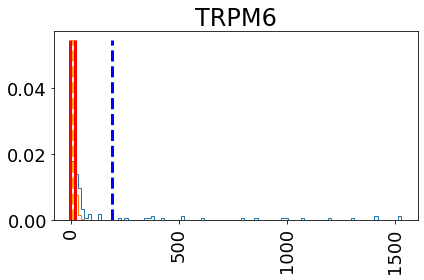

TRPM8
TRPS1
TRPV2
TRPV6
TSHR
TSPAN1


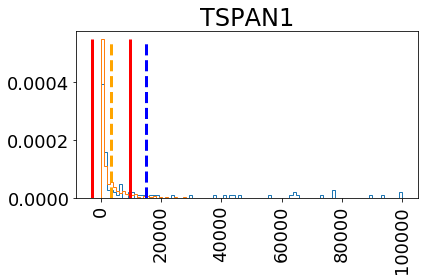

TSPAN19
TSPAN2
TSPAN7
TSPAN8


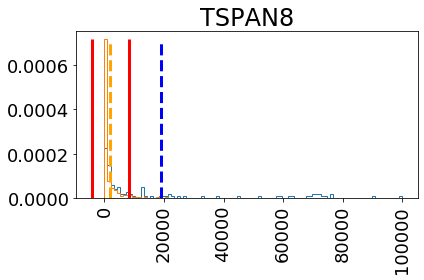

TTC22
TTC29
TTC36
TTC39A
TTC39C
TTC9
TTN
TTPA
TTR
TTYH1
TUBA3C
TUBA3D
TUBA3E
TUBAL3


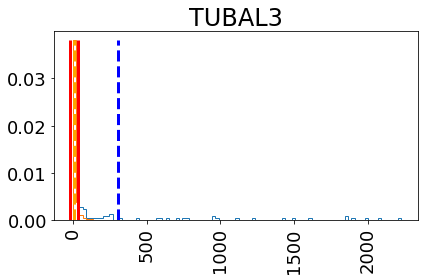

TUBB2B
TUBB3
TUBB4A
TUSC5
TWIST1
TYMS
TYR
TYROBP
UBD
UBE2C
UCHL1
UCN3
UGDH
UGT1A1
UGT1A10
UGT1A4
UGT1A6
UGT1A7
UGT1A8
UGT1A9
UGT2A1
UGT2A3


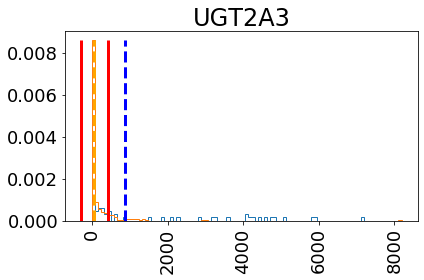

UGT2B11
UGT2B17


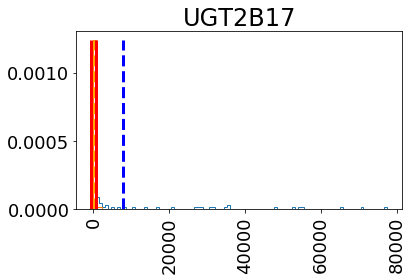

UGT2B4
UGT2B7
UGT3A1
ULBP2
UMODL1
UNC45B
UPB1
UPK1A
UPK1B
UPK3A
UPK3B
UPK3BL
UPP1
USH1C


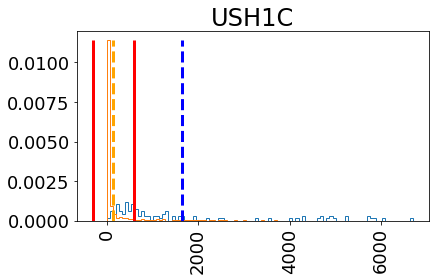

VAV3
VAX1
VCAN
VCX
VCX3A
VCX3B
VEPH1
VGF
VGLL1
VGLL2
VIL1


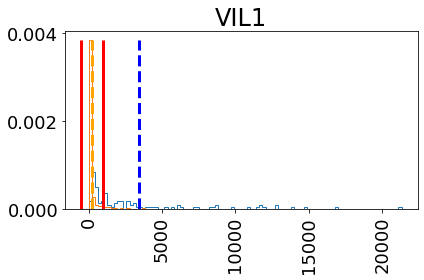

VILL


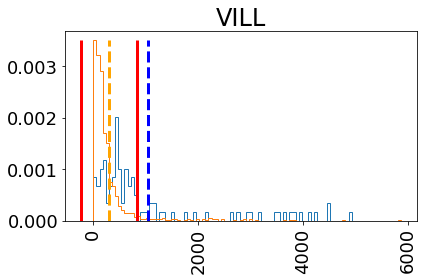

VIP


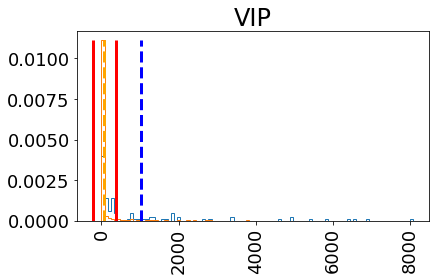

VIPR1


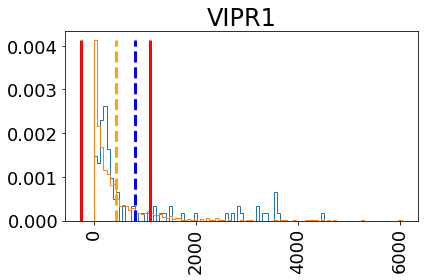

VMO1
VNN1
VNN3
VSIG1
VSIG10L
VSIG2


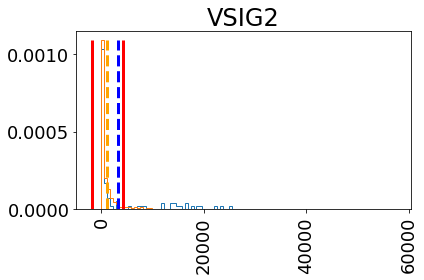

VSIG4
VSIG8
VSNL1
VSTM2A
VSTM2L
VTCN1
VTN
VWA3A
VWA5B1
VWA5B2
VWF
WARS
WDR38
WDR72
WDR86
WFDC1
WFDC12
WFDC3
WFDC5
WFIKKN2
WIF1
WISP2
WNK2


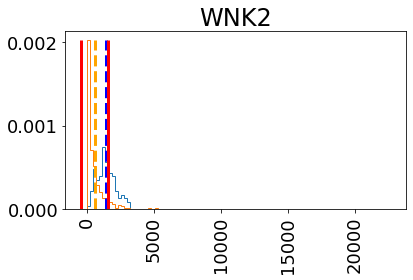

WNT1
WNT2
WNT4
WNT7B
WSCD2
WT1
XAF1
XAGE1A
XAGE1B
XAGE1C
XAGE1D
XAGE1E
XDH
XIRP1
XIRP2
XPNPEP2
YIPF7
ZBBX
ZBED2
ZBTB18
ZBTB7C
ZCCHC12
ZDHHC11B
ZDHHC22


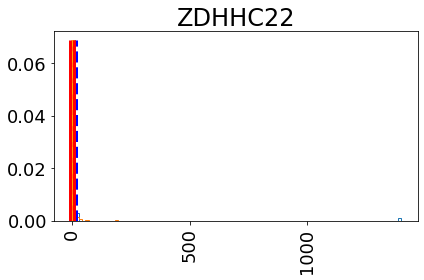

ZG16


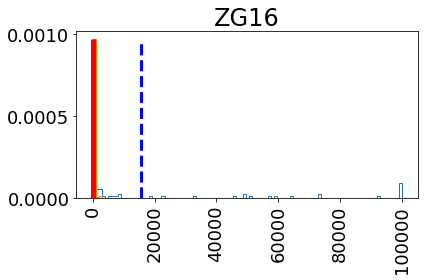

ZG16B
ZIC1
ZIC3
ZMAT4
ZMYND10
ZNF185
ZNF385B
ZNF560
ZNF668
ZNF750
ZNF812
ZPLD1


In [64]:
for gene in df.index:
    print(gene)
    bins=np.linspace(1e-1,df.loc[gene,:].max(),100)
    T_data = df[get_site_columns()].loc[gene,:].astype(float).values
    NT_data = df[get_not_site_columns()].loc[gene,:].astype(float).values
    T_mean = T_data.mean()
    NT_mean = NT_data.mean()
    NT_sigma = NT_data.std()
    sigmadiff.append([gene, np.abs(NT_mean-T_mean)/NT_sigma])
    if np.abs(NT_mean-T_mean) > 0.5*NT_sigma:
        fig=plt.figure()
        plt.title(gene)
        nT,_,_ = plt.hist(T_data, density=True, histtype='step', bins=bins)
        nNT,_,_ = plt.hist(NT_data, density=True, histtype='step', bins=bins)
        plot_max = np.where(nT>nNT,nT,nNT).max()
        plt.vlines([T_mean, NT_mean],0,plot_max, linestyles='dashed', colors=['b','orange'])
        plt.vlines([NT_mean-NT_sigma, NT_mean+NT_sigma],0, plot_max, colors='red')
        plt.tick_params(labelsize=18)
        plt.xticks(rotation=90)
        plt.show()
        HDE_genes.append(gene)

In [65]:
means = df.parallel_apply(lambda x: x[get_not_site_columns()].mean(), axis=1)
variances = df.parallel_apply(lambda x: x[get_not_site_columns()].var(), axis=1)
means_T = df.parallel_apply(lambda x: x[get_site_columns()].mean(), axis=1)
variances_T = df.parallel_apply(lambda x: x[get_site_columns()].var(), axis=1)

In [66]:
df_info = pd.DataFrame(index=df.index)
df_info.insert(0,'mean', means)
df_info.insert(1,'std', variances.apply(np.sqrt))
df_info.insert(2,'mean_T', means_T)
df_info.insert(3,'std_T', variances_T.apply(np.sqrt))
df_info.insert(4,'(mean-mean_T)/std', (means-means_T).apply(np.abs)/variances.apply(np.sqrt))
df_info.insert(5,'cv2_T', variances_T/means_T/means_T)
df_info.insert(6,'cv2', variances/means/means)
df_info = df_info.sort_values(by='(mean-mean_T)/std', ascending=False)

In [67]:
#df_info.to_csv("df_info.csv", index=True, header=True)
df_info = pd.read_csv("df_info.csv", index_col=0)
df_info

,mean,std,mean_T,std_T,(mean-mean_T)/std,cv2_T,cv2
CYP4Z1,10.128836,28.171433,1547.455301,4523.240775,54.570403,8.544038,7.735685
CLEC3A,7.790975,73.845269,2766.924657,10286.262910,37.363716,13.820399,89.838333
NAT1,141.227796,155.827609,2903.555826,5784.444436,17.726820,3.968834,1.217442
FSIP1,8.504297,10.139476,177.305504,268.890389,16.647921,2.299885,1.421524
TRPS1,110.056509,120.361485,1902.367324,1601.640372,14.891066,0.708829,1.196034
...,...,...,...,...,...,...,...
RASD2,164.112591,718.391796,164.030906,264.116045,0.000114,2.592616,19.161916
CCDC39,19.642391,32.673627,19.645868,20.922074,0.000106,1.134141,2.766980
CAMK2N2,26.158133,78.470222,26.164183,72.440047,0.000077,7.665546,8.999042
TRIB1,1122.149686,1242.529084,1122.215284,996.587885,0.000053,0.788640,1.226059


In [68]:
HDE_genes = df_info.index.values

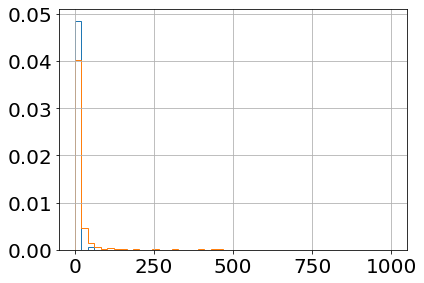

In [69]:
fig, ax=plt.subplots()
df.loc['CYP4Z1',get_site_columns()].hist(density=True, ax=ax, bins=np.linspace(0,1000,50), histtype='step')
df.loc['CYP4Z1',get_not_site_columns()].hist(density=True, ax=ax, bins=np.linspace(0,1000,50), histtype='step')

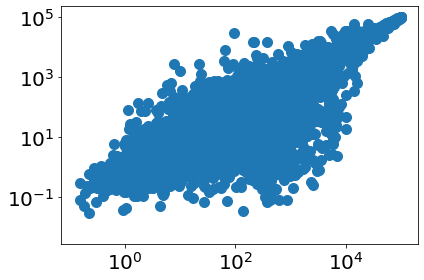

In [70]:
plt.scatter(df_info['mean'], df_info['mean_T'])
plt.xscale('log')
plt.yscale('log')

(0.01, 100000.0)

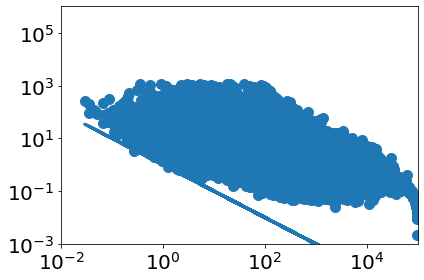

In [71]:
plt.scatter(df_info['mean_T'],df_info['cv2_T'])
plt.plot(df_info['mean_T'],1./df_info['mean_T'])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3,1e6)
plt.xlim(1e-2,1e5)

In [72]:
with open("HDE_Colon.txt", 'w') as f:
    for g in HDE_genes:
        f.write("%s\n"%g)

In [73]:
df_conversion = pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&col=gd_pub_ensembl_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", sep="\t", index_col=0)

In [74]:
pd.Series(data=map(lambda g: df_conversion.at[g, 'Ensembl gene ID'] if g in df_conversion.index else None, HDE_genes)).dropna().to_csv("HDE_colon.csv", index=False)

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
